In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PowerTransformer
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt

In [2]:
# установим опции лимита отображения чисел в научной нотации, а так же вывод списка колонок без сокращений
pd.set_option('display.float_format', lambda x: '%.1f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_seq_items', None)

In [3]:
# флаг запуска ячеек EDA анализа, после завершения процесса EDA нет необходимости повторно прогонять все процессы, так что я отключал его после получения
# финального списка фич и методов их обработки
flag_run_eda_section = True

In [4]:
# Импорт датасетов
train = pd.read_csv('./data/shift_ml_2026_train.csv', dtype={'совокупный_статус_подтверждения_доходов_заемщиков':'str'})
target = train['итоговый_статус_займа']
test = pd.read_csv('./data/shift_ml_2026_test.csv', dtype={'совокупный_статус_подтверждения_доходов_заемщиков':'str'})

### EDA

In [5]:
# посмотрим общую картину по датасету
if flag_run_eda_section:
    train.info()

<class 'pandas.DataFrame'>
RangeIndex: 1210779 entries, 0 to 1210778
Columns: 109 entries, id to тип_предоставления_кредита
dtypes: float64(84), int64(6), object(1), str(18)
memory usage: 1006.9+ MB


In [6]:
# пробежимся по колонкам, чтобы сформировать общую интуицию того, какие данные представленны в датасете и что, гипотетитчески может быть полезным или нет
if flag_run_eda_section:
    train.columns

In [7]:
if flag_run_eda_section:
    # видим, что есть колонка смешанного типа - object, нужно разобраться, что с ней не так и привести к верному формату (хотя бы первоначально)
    # для последующей обработки
    df_temp = train.select_dtypes(include='object', exclude='str')
    print(df_temp.value_counts())
    print(df_temp.isna().sum())
    print(df_temp.shape)

    # увидели, что это 'пени_за_дефолт', поскольку мы предсказываем вероятность будущего дефолта, но этот столбец не играет весомой роли, а так же имеет
    # пропусков более 40%, поэтому его можно просто дропнуть
    train = train.drop('пени_за_дефолт', axis=1)
    train.info()

пени_за_дефолт
False             735956
True              111382
Name: count, dtype: int64
пени_за_дефолт    363441
dtype: int64
(1210779, 1)
<class 'pandas.DataFrame'>
RangeIndex: 1210779 entries, 0 to 1210778
Columns: 108 entries, id to тип_предоставления_кредита
dtypes: float64(84), int64(6), str(18)
memory usage: 997.7 MB


In [8]:
if flag_run_eda_section:
    # проверим есть ли столбцы, заполненные нанками равным или более установленному уровню в 90% и удалим такие столбцы, так как данные из них скорее
    # будут вносить шум, чем давать пользу
    treshold = int(round(0.1 * train.shape[0], 0))
    df_tresh = train.loc[:, train.isna().sum() >=  train.shape[0] - treshold]
    print(df_tresh.columns)
    print(f'Удалим {len(df_tresh.columns)} столбцов')

    train = train.dropna(thresh=treshold, axis='columns')
    train.info()

Index(['дата_следующей_выплаты', 'совокупный_доход_заемщиков',
       'совокупный_пдн_заемщиков',
       'совокупный_статус_подтверждения_доходов_заемщиков',
       'кредитный_баланс_по_возоб_счетам'],
      dtype='str')
Удалим 5 столбцов
<class 'pandas.DataFrame'>
RangeIndex: 1210779 entries, 0 to 1210778
Columns: 103 entries, id to тип_предоставления_кредита
dtypes: float64(80), int64(6), str(17)
memory usage: 951.5 MB


In [9]:
if flag_run_eda_section:
    # проверим и дропнем дубли
    train = train.drop_duplicates()
    train.shape

In [10]:
if flag_run_eda_section:
    # пройдемся по строковым столбцам и посмотрим как их можно подготовить и/или преобразовать
    df_str = train.select_dtypes('str')
    print(df_str.info())
    df_str.head()

<class 'pandas.DataFrame'>
RangeIndex: 1210779 entries, 0 to 1210778
Data columns (total 17 columns):
 #   Column                       Non-Null Count    Dtype
---  ------                       --------------    -----
 0   срок_займа                   1210779 non-null  str  
 1   рейтинг                      1210779 non-null  str  
 2   допрейтинг                   1210779 non-null  str  
 3   профессия_заемщика           1133730 non-null  str  
 4   стаж                         1140271 non-null  str  
 5   владение_жильем              1210779 non-null  str  
 6   подтвержден_ли_доход         1210779 non-null  str  
 7   платежный_график             1210779 non-null  str  
 8   цель_займа                   1210779 non-null  str  
 9   регион                       1210779 non-null  str  
 10  пос_стоп_фактор              1210779 non-null  str  
 11  юридический_статус           1210779 non-null  str  
 12  дата_первого_займа           1210779 non-null  str  
 13  первоначальный_статус_з

Теперь видно, что:
- "срок займа" нужно перевести в цифры, например кратно месяцам
- "стаж" так же перевести в цифры, кратно либо месяцам, либо годам
- "допрейтинг" содержит и "рейтинг", поэтому всё, что нужно сделать - это проверить соответствие букве рейтинга букве допрейтинга, а потом
категоризировать и заэнкодить допрейтинг, переведя букву в цифру, а рейтинг дропнуть (не использовать в качестве фичи)
- "регион" нужно так же заэнкодить, например используя законодательно принятые цифры регионов
- "дата первого займа" - это не строка, а дата в формате месяц-год, поэтому конвертнем ее
- остальные столбцы после анализа уникальных значений заэнкодим соответственно

In [11]:
if flag_run_eda_section:
    # начнем с двух столбцов рейтинга
    # проверим есть ли нанки в рейтинге и потом проверим вхождение всех значений рейтинга в допрейтинг
    print(df_str['рейтинг'].isna().sum())

    df_match = (df_str.apply(lambda x: x['рейтинг'] in x['допрейтинг'], axis=1))
    print(df_match.value_counts())
    print(df_match.info())

0
True    1210779
Name: count, dtype: int64
<class 'pandas.Series'>
RangeIndex: 1210779 entries, 0 to 1210778
Series name: None
Non-Null Count    Dtype
--------------    -----
1210779 non-null  bool 
dtypes: bool(1)
memory usage: 1.2 MB
None


In [12]:
# создадим для LE функцию для матчинга букв - цифр
def rating_le(_rating: str) -> int:
    _char = _rating[0]
    _end = _rating[1]
    cases = {
        'А': '1',
        'Б': '2',
        'В': '3',
        'Г': '4',
        'Д': '5',
        'Е': '6',
        'Ж': '7'
    }
    res = '99'
    if _char in cases.keys():
        res = cases[_char]
    res += _end
    return res

if flag_run_eda_section:
    # всё ок, теперь можно заменить буквы рейтинга цифрами, сконвертировать формат столбца и дропнуть "рейтинг" из фич
    # вместо one-hot encoding (далее - OHE) используем label encoding (далее - LE) тем самым мы не будем генерить чрезмерно большое количество доп. фич,
    # что сэкономит ресурсы машины, а так же дополнительно "внесем смысл" в рейтинг клиента - чем меньшее получилось число, тем более
    # высокий рейтинг надежности клиента, например А1 преварщается в 11, а Ж2 в 72.

    df_str = df_str.drop('рейтинг', axis=1)
    df_str['допрейтинг'] = df_str['допрейтинг'].apply(lambda x: rating_le(x))
    df_str['допрейтинг'] = df_str['допрейтинг'].astype(int)
    df_str.head()

Теперь последовательно пойдем по остальным столбцам проверяя, очищая данные и делая либо OHE либо LE

In [13]:
if flag_run_eda_section:
    print(df_str['срок_займа'].isna().sum())
    print(df_str['срок_займа'].unique())

    # переведем года в месяцы и изменим формат столбца
    df_str['срок_займа'] = (df_str['срок_займа'].apply(lambda x: int(x[0]) * 12)).astype(int)

0
<StringArray>
['3 года', '5 лет']
Length: 2, dtype: str


In [14]:
if flag_run_eda_section:
    # "профессия_заемщика" - это важный категориальный признак и если бы это был реальный пайплайн, то, возможно, принесло бы доп. эффективность использование ллм
    # для анализа категории профессии, условно что-то типа все виды директоров, руководителей относим к категории топ-менеджмент, который потом в пайплайне
    # кодируется, например 1, инженеры, программисты к категории технических специалистов, с лэйблом 2 и т.д. Но в рамках текущего задания, думаю
    # целесообразнее будет просто дропнуть этот столбец из списка фич
    df_str = df_str.drop('профессия_заемщика', axis=1)

In [15]:
if flag_run_eda_section:
    # переходим к стажу, так же проанализируем значения, нанки и переведем в целые года, если не встретятся варианты с месяцами, если встретятся, то переведем
    # в месяца как со сроком займа
    print(df_str['стаж'].isna().sum())
    print(df_str['стаж'].unique())

70508
<StringArray>
[ '10+ лет',   '4 года',    '6 лет',   '3 года',    '7 лет',    '8 лет',
   '2 года',    '5 лет',    '9 лет', '< 1 года',    '1 год',        nan]
Length: 12, dtype: str


In [16]:
if flag_run_eda_section:
    # поскольку у нас есть категория стажа меньше года, то закодируем ее нулём, туда же целесообразно отнести и тех клиентов, про стаж которых ничего не известно,
    # так как чем меньше стаж, тем меньше информации о надежности и платежеспособности клиента, тем риск получения высокой вероятности дефолта выше
    df_str['стаж'] = df_str['стаж'].str.replace('< 1 года', '0')
    df_str['стаж'] = df_str['стаж'].str.replace('10+ лет', '10')
    df_str['стаж'] = df_str['стаж'].fillna('0')
    df_str['стаж'] = (df_str['стаж'].apply(lambda x: x[0])).astype(int)

In [17]:
if flag_run_eda_section:
    # к столбцу "владение_жильем" так же применим LE после проверки и очистки данных
    print(df_str['владение_жильем'].isna().sum())
    print(df_str['владение_жильем'].unique())

0
<StringArray>
['ИПОТЕКА', 'АРЕНДА', 'СОБСТВЕННОСТЬ', 'ЛЮБОЕ', 'НЕТ', 'ДРУГОЕ']
Length: 6, dtype: str


In [18]:
if flag_run_eda_section:
    def real_estate_ownrshp_le(_char: str) -> int:
        cases = {
            'НЕТ': '0',
            'СОБСТВЕННОСТЬ': '1',
            'АРЕНДА': '2',
            'ИПОТЕКА': '3',
            'ЛЮБОЕ': '4',
            'ДРУГОЕ': '5'
        }
        res = 5
        if _char in cases.keys():
            res = cases[_char]
        return res

    df_str['владение_жильем'] = df_str['владение_жильем'].apply(lambda x: real_estate_ownrshp_le(x))
    df_str['владение_жильем'] = df_str['владение_жильем'].astype(int)

In [19]:
if flag_run_eda_section:
    # к столбцу "подтвержден_ли_доход" так же применим LE после проверки и очистки данных
    print(df_str['подтвержден_ли_доход'].isna().sum())
    print(df_str['подтвержден_ли_доход'].unique())

0
<StringArray>
['Не подтвержден', 'Подтвержден источник', 'Подтвержден']
Length: 3, dtype: str


In [20]:
if flag_run_eda_section:
    # так же напишем функцию для LE, все иные значения, которые отсутствуют в трэйне, но могут быть в тесте мы так же будем относить к категории "Не подтвержден"
    def funds_origin_le(_char: str) -> int:
        cases = {
            'Не подтвержден': '0',
            'Подтвержден источник': '1',
            'Подтвержден': '2'
        }
        res = 0
        if _char in cases.keys():
            res = cases[_char]
        return res

    df_str['подтвержден_ли_доход'] = df_str['подтвержден_ли_доход'].apply(lambda x: funds_origin_le(x))
    df_str['подтвержден_ли_доход'] = df_str['подтвержден_ли_доход'].astype(int)

In [21]:
if flag_run_eda_section:
    # посмотрим состав столбца "платежный_график"
    print(df_str['платежный_график'].isna().sum())
    print(df_str['платежный_график'].unique())

    # так как там только одно значение, то мы его просто дропаем за ненадобностью
    df_str = df_str.drop('платежный_график', axis=1)

0
<StringArray>
['n']
Length: 1, dtype: str


In [22]:
if flag_run_eda_section:
    # к столбцу "цель_займа" так же применим LE после проверки и очистки данных
    print(df_str['цель_займа'].isna().sum())
    print(df_str['цель_займа'].unique())

0
<StringArray>
[             'мелкий_бизнес', 'улучшение_жилищных_условий',
         'консолидация_долга',            'крупная_покупка',
            'кредитная_карта',                     'другое',
                        'дом',                     'отпуск',
                    'лечение',                 'автомобиль',
                    'переезд',     'возобновляемая_энергия',
                    'свадьба',                'образование']
Length: 14, dtype: str


In [23]:
if flag_run_eda_section:
    # поскольку значений уже стало больше и на тестовой выборке может еще добавиться, то при создании функции лэйбл энкодинга попробуем это учесть
    loan_goal_keys = df_str['цель_займа'].unique()
    loan_goal_values = np.arange(0, len(loan_goal_keys))
    loan_goal_dict = dict(zip(loan_goal_keys, loan_goal_values))

    df_str['цель_займа'] = df_str['цель_займа'].apply(lambda x: loan_goal_dict[x])
    df_str['цель_займа'] = df_str['цель_займа'].astype(int)

In [24]:
if flag_run_eda_section:
    # к столбцу "регион" так же применим LE после проверки и очистки данных
    print(df_str['регион'].isna().sum())
    print(df_str['регион'].unique())

0
<StringArray>
[             'Новгородская область',              'Республика Татарстан',
                   'Республика Коми',                   'Томская область',
              'Белгородская область',                  'Амурская область',
                 'Республика Адыгея',           'Калининградская область',
                'Московская область',               'Кемеровская область',
               'Магаданская область',                'Республика Бурятия',
         'Ненецкий автономный округ',             'Новосибирская область',
             'Ленинградская область',              'Астраханская область',
             'Нижегородская область',                   'Курская область',
                'Забайкальский край',              'Оренбургская область',
                 'Иркутская область',                  'Хабаровский край',
 'Ханты-Мансийский автономный округ',               'Ярославская область',
                 'Калужская область',          'Республика Саха (Якутия)',
   'Ямало

In [25]:
if flag_run_eda_section:
    # в идеале, нужно заэнкодить согласно реальному номеру региона, но в целях экономии времени воспользуемся приемом с рэндомным кодом
    region_keys = df_str['регион'].unique()
    region_values = np.arange(0, len(region_keys))
    region_dict = dict(zip(region_keys, region_values))

    df_str['регион'] = df_str['регион'].apply(lambda x: region_dict[x])
    df_str['регион'] = df_str['регион'].astype(int)

In [26]:
if flag_run_eda_section:
    # к столбцу "пос_стоп_фактор" так же применим LE после проверки и очистки данных
    print(df_str['пос_стоп_фактор'].isna().sum())
    print(df_str['пос_стоп_фактор'].unique())
    st_factor_keys = df_str['пос_стоп_фактор'].unique()
    st_factor_values = np.arange(0, len(st_factor_keys))
    st_factor_dict = dict(zip(st_factor_keys, st_factor_values))

    df_str['пос_стоп_фактор'] = df_str['пос_стоп_фактор'].apply(lambda x: st_factor_dict[x])
    df_str['пос_стоп_фактор'] = df_str['пос_стоп_фактор'].astype(int)

0
<StringArray>
['Нет', 'Под вопросом', 'Да']
Length: 3, dtype: str


In [27]:
if flag_run_eda_section:
    # к столбцу "юридический_статуc" так же применим LE после проверки и очистки данных
    print(df_str['юридический_статус'].isna().sum())
    print(df_str['юридический_статус'].unique())
    jur_st_keys = df_str['юридический_статус'].unique()
    jur_st_values = np.arange(0, len(jur_st_keys))
    jur_st_dict = dict(zip(jur_st_keys, jur_st_values))

    df_str['юридический_статус'] = df_str['юридический_статус'].apply(lambda x: jur_st_dict[x])
    df_str['юридический_статус'] = df_str['юридический_статус'].astype(int)

0
<StringArray>
['Нет', 'Да']
Length: 2, dtype: str


In [28]:
if flag_run_eda_section:
    # к столбцу "дата_первого_займа" переведем в таймстепм
    print(df_str['дата_первого_займа'].isna().sum())
    print(df_str['дата_первого_займа'].unique())
    df_str['дата_первого_займа'] = pd.to_datetime(df_str['дата_первого_займа'], format='%m-%Y')

    # наверное от самой даты как таковой особо пользы не будет, поэтому сгенерим фичу, основанную на этой дате как количество дней, прошедшее с даты
    # первого займа допустим до 02-2026, а сам столбец даты первого займа дропнем из списка итоговых фич
    dt_to_compare = pd.to_datetime('02-2026', format='%m-%Y')
    df_str['дней_от_первого_займа'] = df_str['дата_первого_займа'].apply(lambda x: (dt_to_compare - x).days)
    df_str = df_str.drop('дата_первого_займа', axis=1)

0
<StringArray>
['12-1999',  '8-2000', '10-1987',  '6-1990',  '2-1999',  '4-2002', '11-1994',
  '6-1996',  '6-2005',  '5-1984', '12-2001', '11-1993',  '3-2005',  '5-2004',
  '6-1991',  '5-2000', '10-2011',  '5-1994',  '7-2011',  '5-1991',  '6-2002',
 '12-1985',  '4-2007',  '2-2002',  '6-2001', '10-1996',  '7-2001',  '8-2004',
  '6-2007',  '7-2004',  '4-2001', '10-1999', '11-2001',  '1-2001',  '9-2004',
  '9-2006', '10-2002',  '2-1990',  '8-1987', '10-1998',  '8-2001',  '2-2004',
  '8-2009',  '1-1999',  '6-2000',  '1-2007',  '8-1997', '12-1987',  '6-2004',
 '10-2004', '12-2002', '11-2002', '10-2006',  '9-2000',  '2-2012',  '4-2005',
  '9-1994',  '4-1993',  '9-2007',  '1-1998',  '5-2008',  '3-2001',  '4-1994',
  '4-2003',  '1-2002',  '1-2011', '11-2000',  '5-2002', '11-2003',  '9-2003',
 '12-1997',  '5-2006', '11-2009', '10-1994',  '9-2002',  '6-1999', '11-2006',
 '11-1996',  '2-2000',  '1-1957',  '6-2006',  '8-1974',  '2-2010', '11-2005',
 '12-1983',  '1-1993',  '3-2004',  '8-1998', '12

In [29]:
if flag_run_eda_section:
    # к столбцу "первоначальный_статус_займа" так же применим LE после проверки и очистки данных
    print(df_str['первоначальный_статус_займа'].isna().sum())
    print(df_str['первоначальный_статус_займа'].unique())
    loan_st_keys = df_str['первоначальный_статус_займа'].unique()
    loan_st_values = np.arange(0, len(loan_st_keys))
    loan_st_dict = dict(zip(loan_st_keys, loan_st_values))

    df_str['первоначальный_статус_займа'] = df_str['первоначальный_статус_займа'].apply(lambda x: loan_st_dict[x])
    df_str['первоначальный_статус_займа'] = df_str['первоначальный_статус_займа'].astype(int)

0
<StringArray>
['а', 'б']
Length: 2, dtype: str


In [30]:
if flag_run_eda_section:
    # к столбцу "тип_займа" так же применим LE после проверки и очистки данных
    print(df_str['тип_займа'].isna().sum())
    print(df_str['тип_займа'].unique())
    loan_type_keys = df_str['тип_займа'].unique()
    loan_type_values = np.arange(0, len(loan_type_keys))
    loan_type_dict = dict(zip(loan_type_keys, loan_type_values))

    df_str['тип_займа'] = df_str['тип_займа'].apply(lambda x: loan_type_dict[x])
    df_str['тип_займа'] = df_str['тип_займа'].astype(int)

0
<StringArray>
['Индивидуальный', 'Совместный']
Length: 2, dtype: str


In [31]:
if flag_run_eda_section:
    # к столбцу "особая_ситуация" содержит только одно значение "нет", даже, если на тестовом наборе будет значения "да", то их влияние не будет
    # существенным, поэтому этот столбец дропаем из списка фич
    print(df_str['особая_ситуация'].isna().sum())
    print(df_str['особая_ситуация'].unique())
    df_str = df_str.drop('особая_ситуация', axis=1)

0
<StringArray>
['Нет']
Length: 1, dtype: str


In [32]:
if flag_run_eda_section:
    # к столбцу "тип_предоставления_кредита" так же применим LE после проверки и очистки данных
    print(df_str['тип_предоставления_кредита'].isna().sum())
    print(df_str['тип_предоставления_кредита'].unique())
    loan_transfer_type_keys = df_str['тип_предоставления_кредита'].unique()
    loan_transfer_type_values = np.arange(0, len(loan_transfer_type_keys))
    loan_transfer_type_dict = dict(zip(loan_transfer_type_keys, loan_transfer_type_values))

    df_str['тип_предоставления_кредита'] = df_str['тип_предоставления_кредита'].apply(lambda x: loan_transfer_type_dict[x])
    df_str['тип_предоставления_кредита'] = df_str['тип_предоставления_кредита'].astype(int)

0
<StringArray>
['Наличные', 'Перевод']
Length: 2, dtype: str


In [33]:
if flag_run_eda_section:
    # сохраним все категориальные столбцы в отдельный список
    category_list = df_str.columns.tolist()
    category_list

Теперь пройдемся по столбцам с числовыми данными и посмотрим их состав, наличие выбросов и вариативность значений. Затем проведем нормализацию и заполним пропуски.


сумма_займа
Доля нанок: 0.0



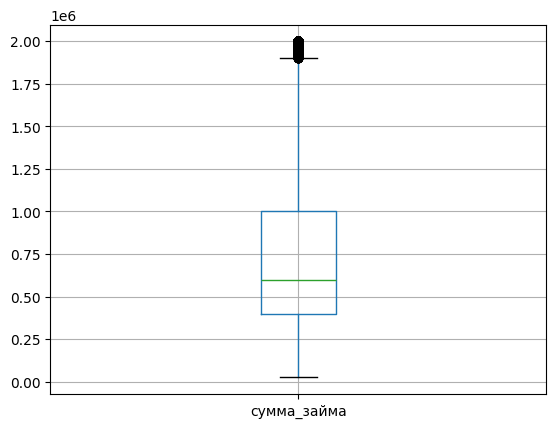


процентная_ставка
Доля нанок: 0.0



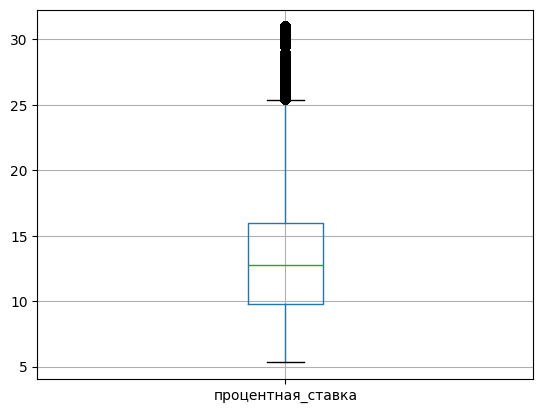


аннуитет
Доля нанок: 0.0



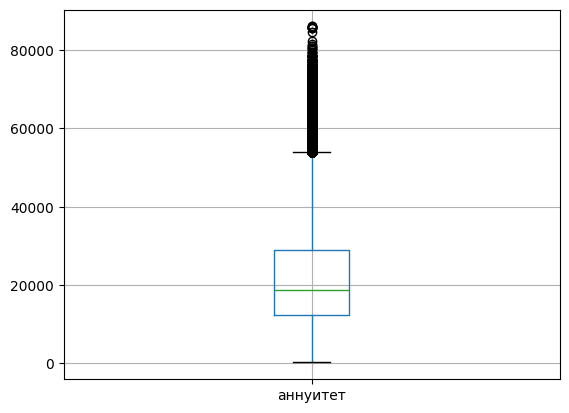


годовой_доход
Доля нанок: 0.0



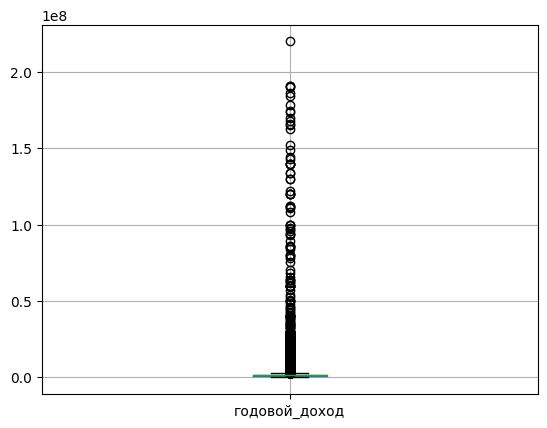


итоговый_статус_займа
Доля нанок: 0.0



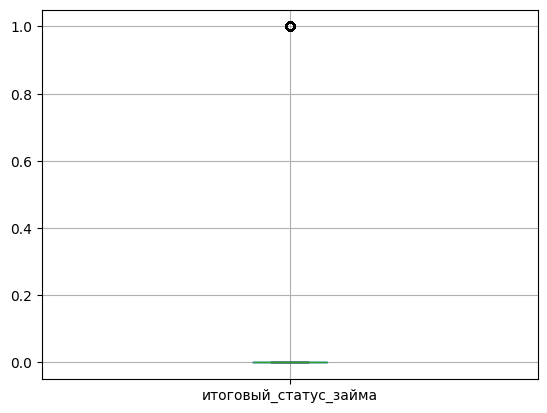


рейтинг_OCR
Доля нанок: 0.0



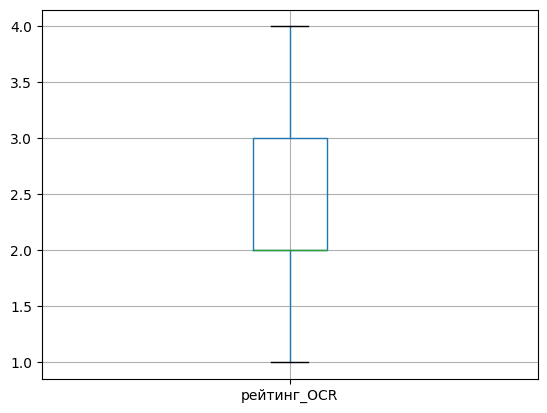


коэфф_акционных_зачислений_в_остатке
Доля нанок: 0.0



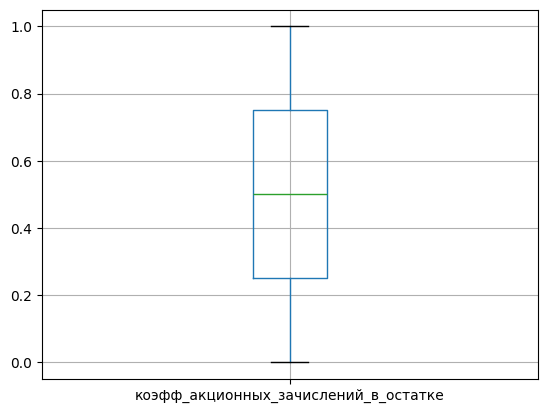


кол_во_субсидий_за_год
Доля нанок: 0.0



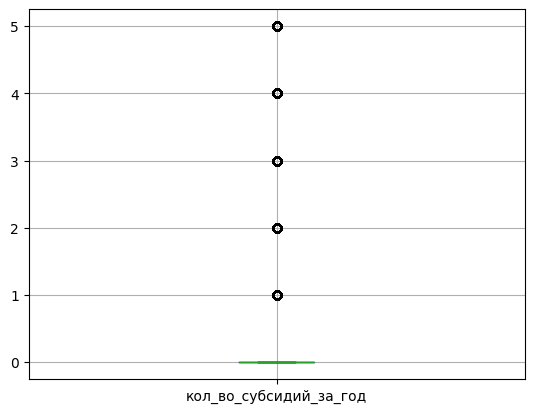


пдн
Доля нанок: 0.0003

Столбец пдн - делаем замену отрицательных значений.


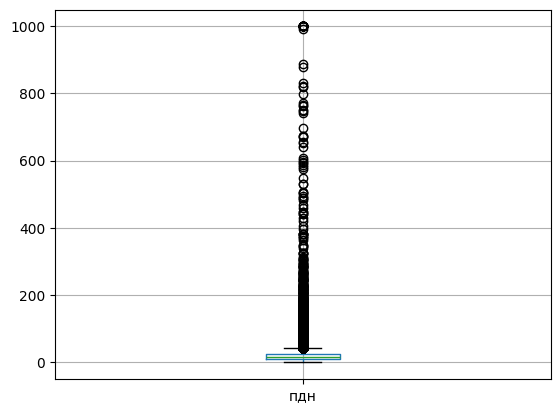


кол-во_просрочек_за_два_года
Доля нанок: 0.0



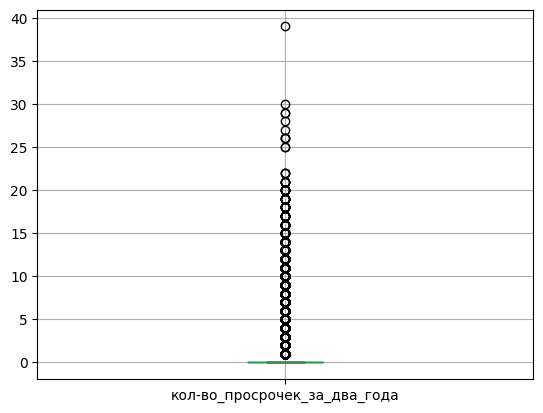


коэфф_исходного_платежа
Доля нанок: 0.0



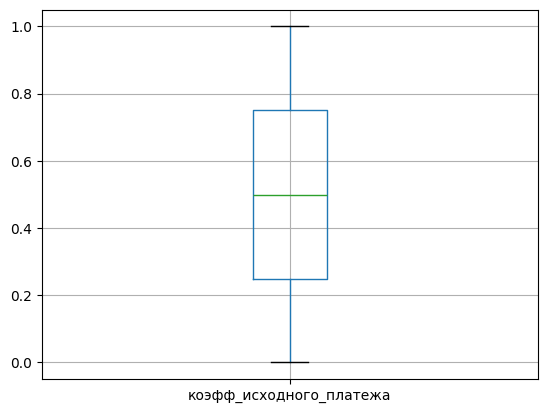


нижний_порог_рейтинга_заемщика
Доля нанок: 0.0



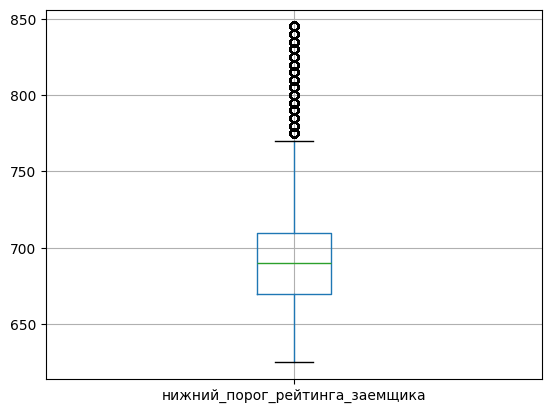


верхний_порог_рейтинга_заемщика
Доля нанок: 0.0



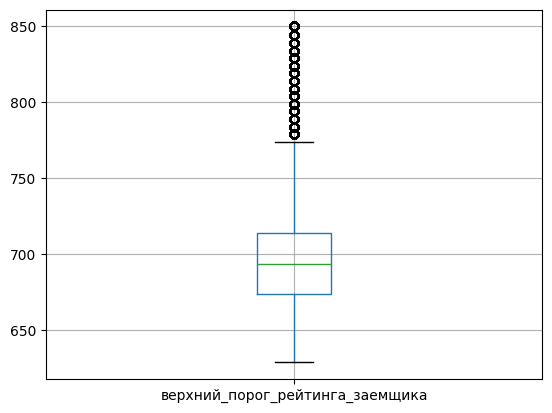


кол-во_заявок_за_полгода
Доля нанок: 0.0



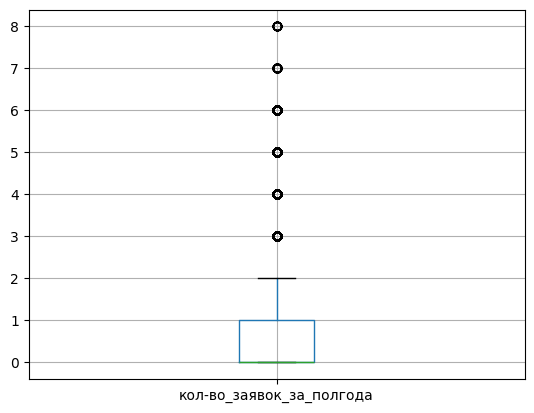


кол-во_месяцев_с_последней_просрочки
Доля нанок: 0.5043



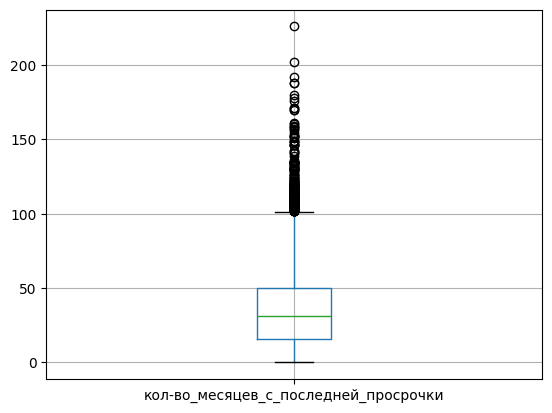


кол-во_месяцев_с_последнего_займа
Доля нанок: 0.8301



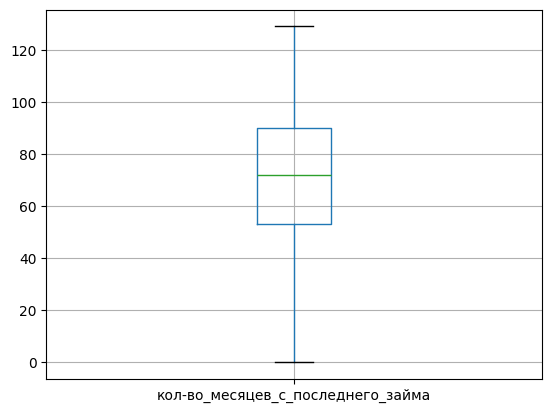


кол-во_открытых_счетов
Доля нанок: 0.0



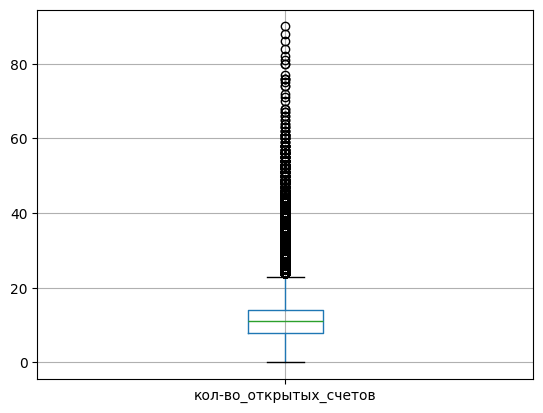


кол-во_записей_в_общедоступных_документах
Доля нанок: 0.0



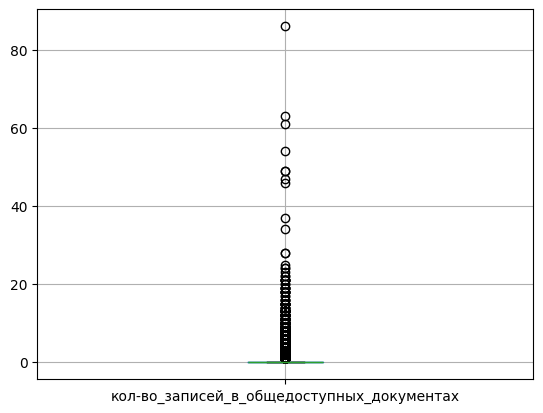


оборотный_баланс
Доля нанок: 0.0



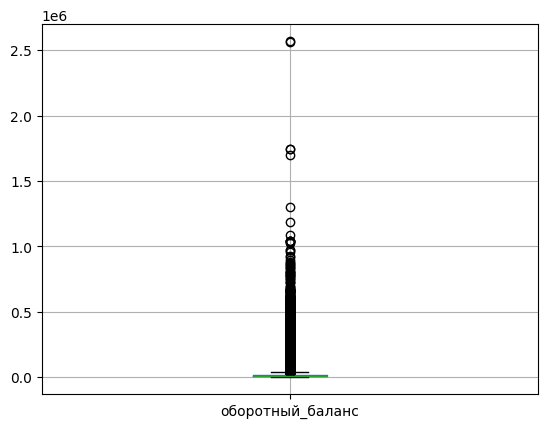


коэфф_загрузки_возобновляемого_счета
Доля нанок: 0.0006



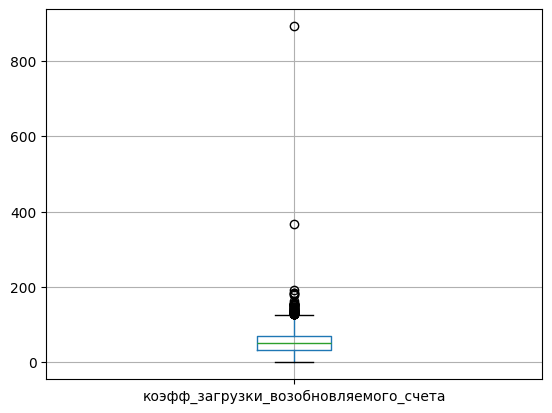


кол-во_счетов
Доля нанок: 0.0



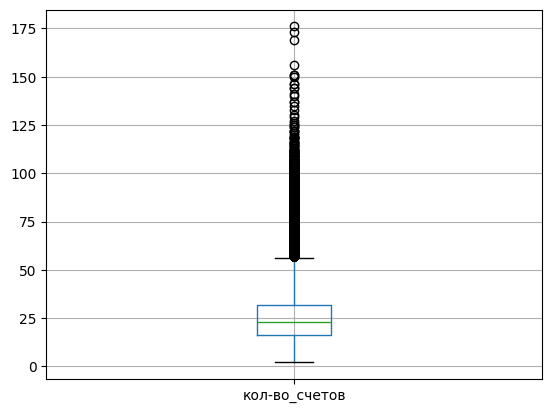


сумма_выплат_по_просрочкам
Доля нанок: 0.0

Столбец сумма_выплат_по_просрочкам - делаем замену отрицательных значений.


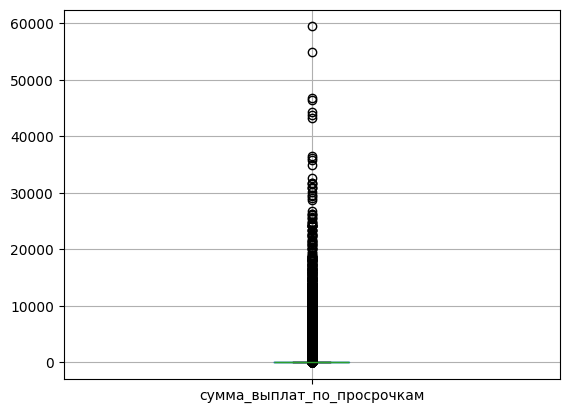


грейд_на_детерминаторе
Доля нанок: 0.0



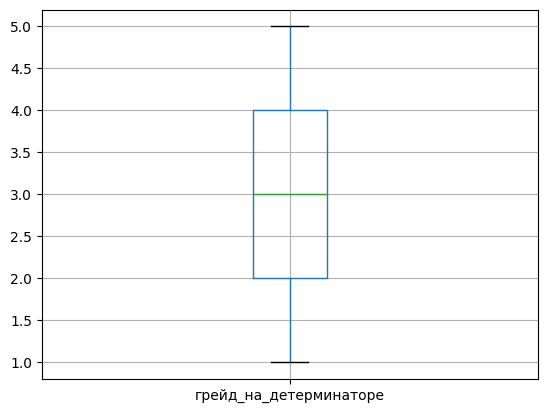


кол-во_взысканий_за_последний_год
Доля нанок: 0.0



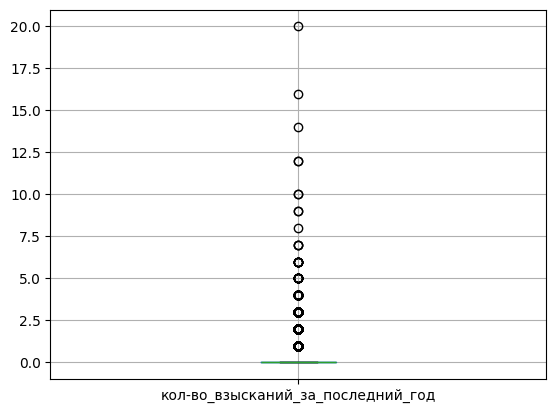


кол-во_месяцев_с_последнего_нарушения
Доля нанок: 0.7368



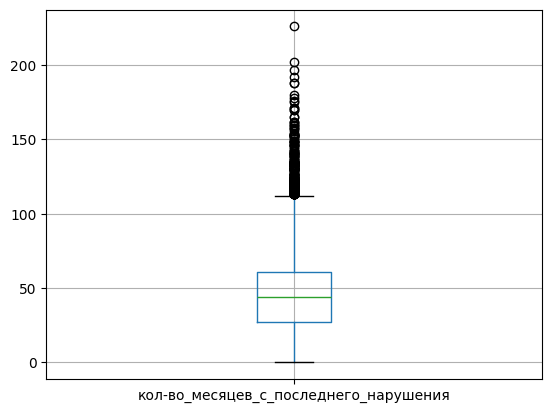


кол-во_текущих_просроченных_счетов
Доля нанок: 0.0



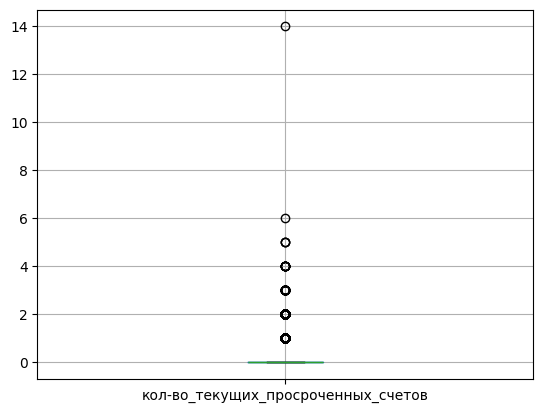


общая_сумма_взысканий
Доля нанок: 0.0502



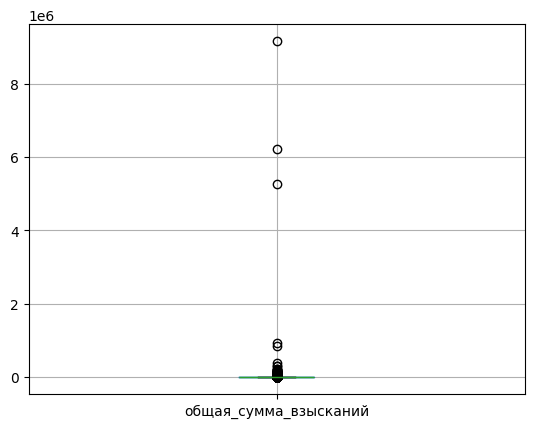


возвраты_с_учетом_мпл
Доля нанок: 0.0



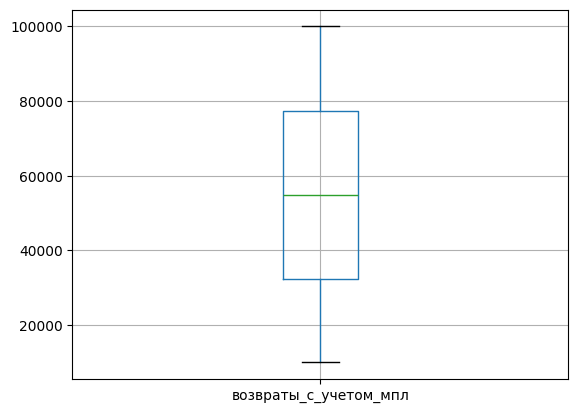


общая_сумма_на_счетах
Доля нанок: 0.0502



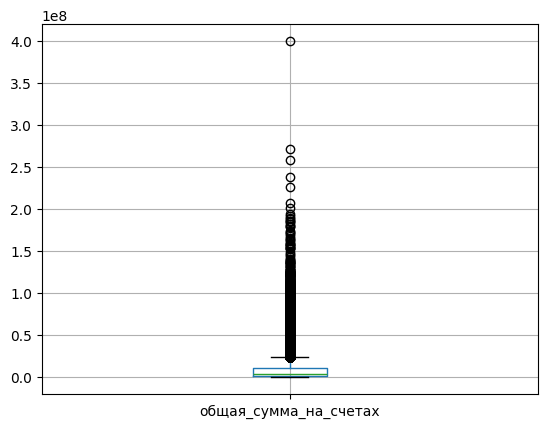


кол-во_открытых_счетов_за_полгода
Доля нанок: 0.6004



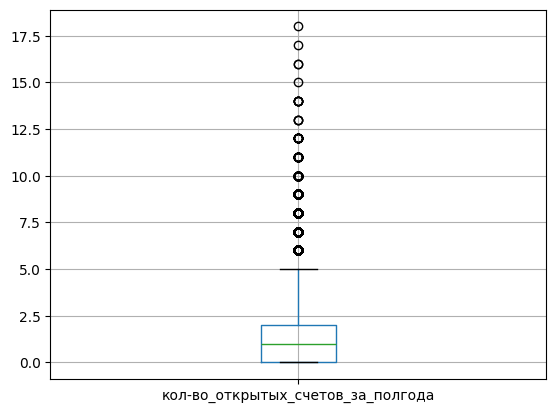


кол-во_текущих_аннуитетных_счетов
Доля нанок: 0.6004



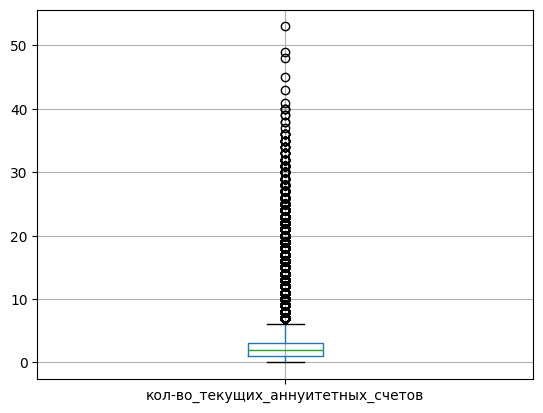


кол-во_аннуитетных_счетов_за_год
Доля нанок: 0.6004



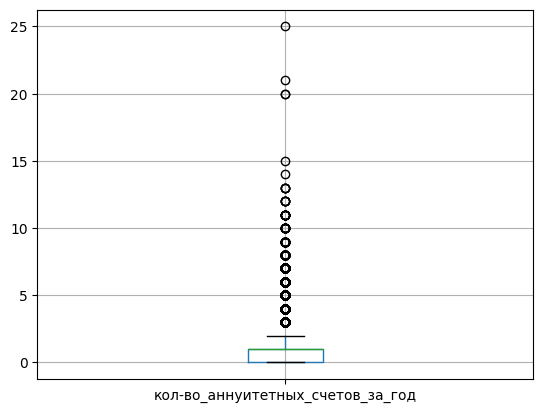


кол-во_аннуитетных_счетов_за_2_года
Доля нанок: 0.6004



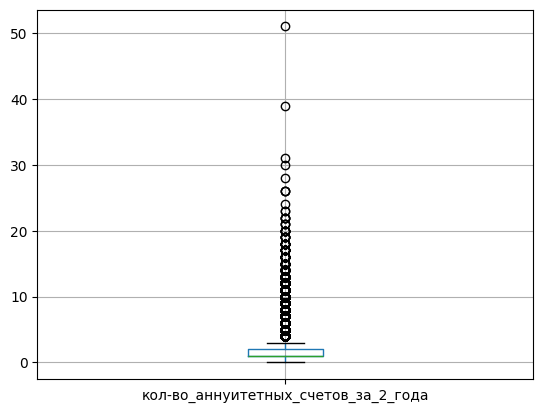


кол-во_месяцев_с_посл_аннуитетного_счета
Доля нанок: 0.6109



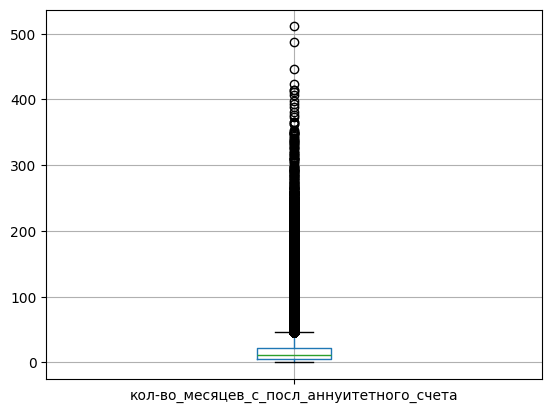


текущий_баланс_по_аннуитетным_счетам
Доля нанок: 0.6004



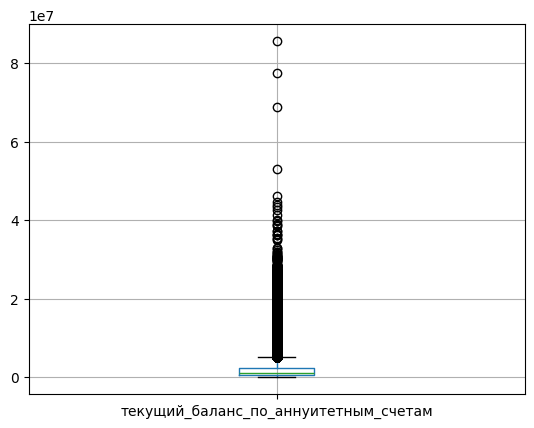


соотношение_сумм_текущего_баланса_к_лимиту_по_аннуитетным_счетам
Доля нанок: 0.6544



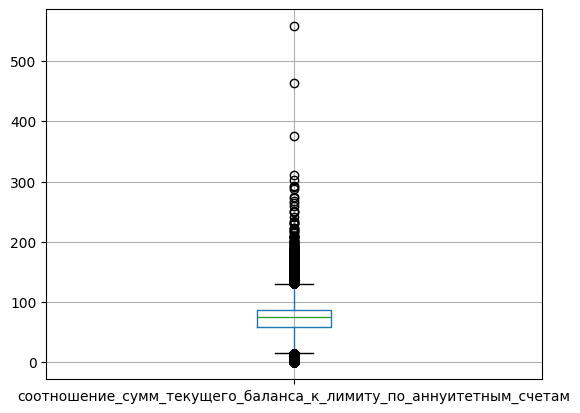


кол-во_возоб_счетов_за_год
Доля нанок: 0.6004



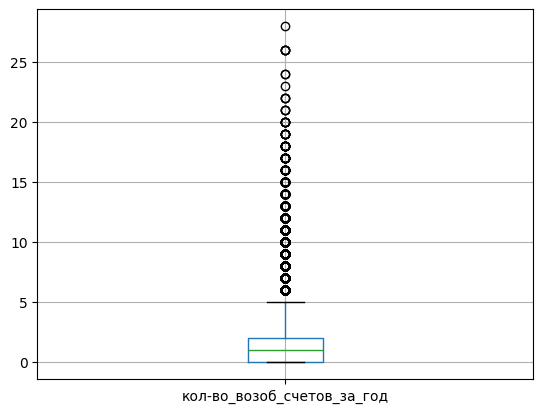


кол-во_возоб_счетов_за_2_года
Доля нанок: 0.6004



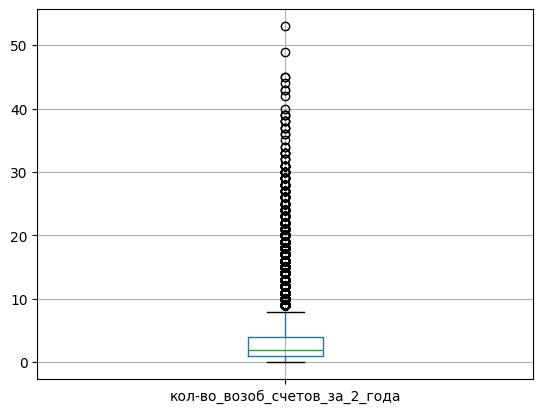


макс_баланс_по_возоб_счетам
Доля нанок: 0.6004



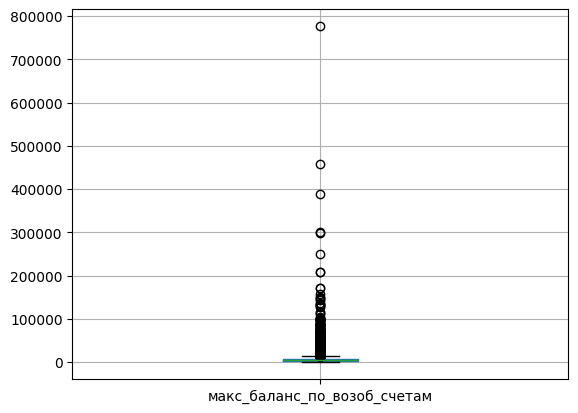


соотношение_баланса_к_лимиту_общее
Доля нанок: 0.6004



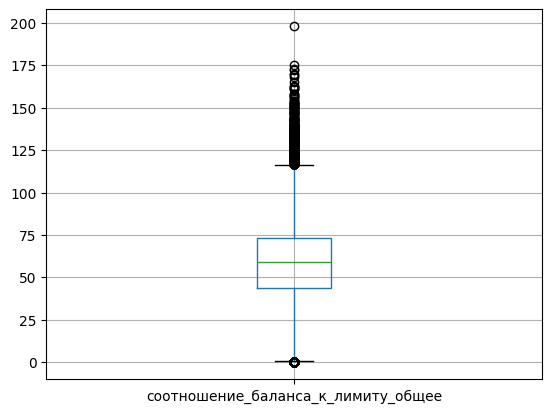


общий_лимит_по_возоб_счету
Доля нанок: 0.0502



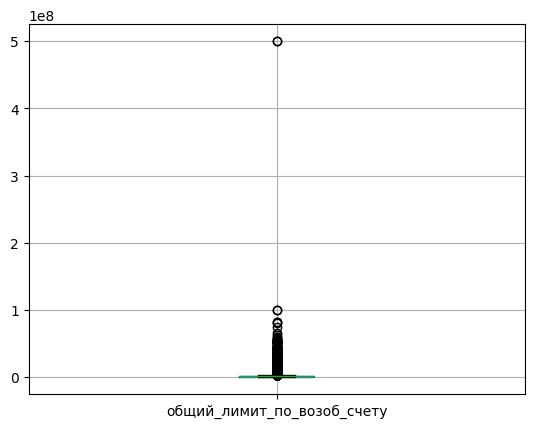


кол-во_финансовых_запросов
Доля нанок: 0.6004



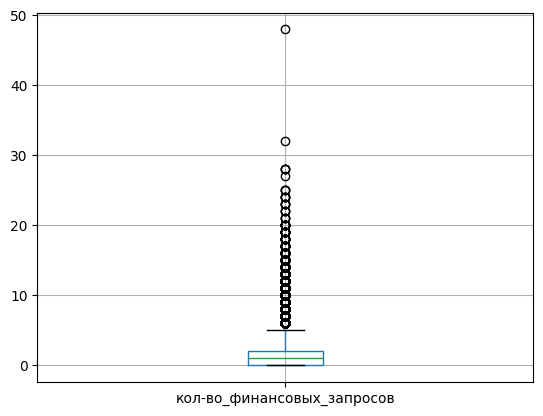


кол-во_финансовых_операций
Доля нанок: 0.6004



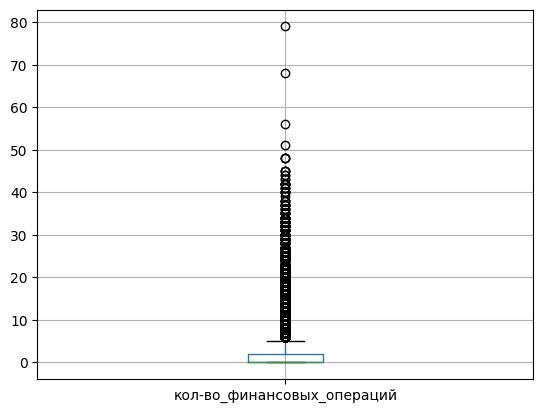


кол-во_заявок_на_кредит_за_год
Доля нанок: 0.6004



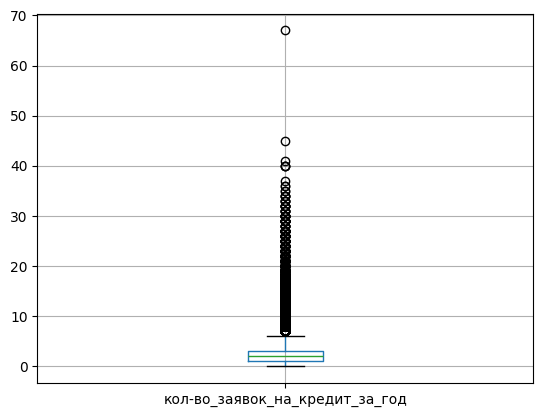


кол-во_открытых_счетов_за_2_года
Доля нанок: 0.0351



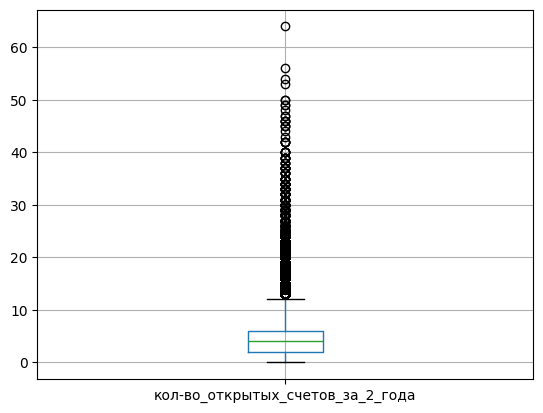


средний_баланс_текущих_счетов
Доля нанок: 0.0502



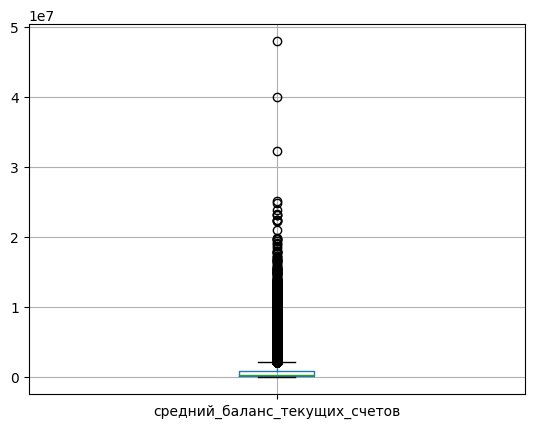


суммарная_доступная_сумма_займа_по_картам
Доля нанок: 0.0454



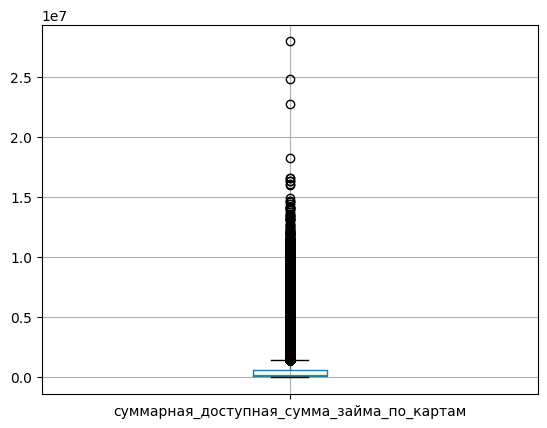


соотношение_баланса_к_лимиту_по_картам
Доля нанок: 0.046



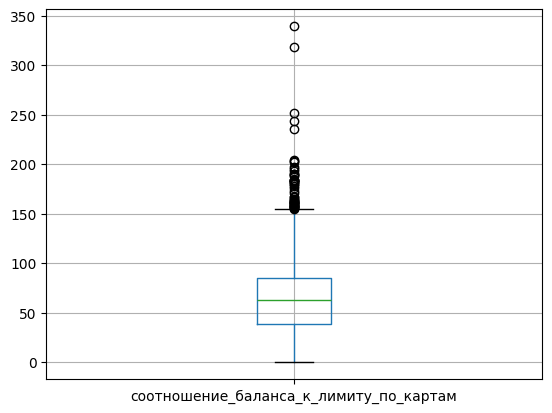


кол-во_списаний_за_год
Доля нанок: 0.0



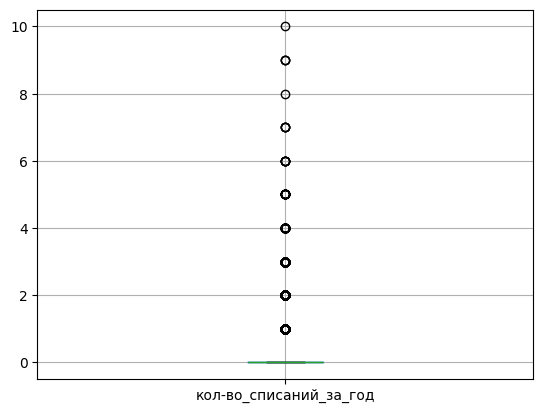


сумма_задолженности
Доля нанок: 0.0



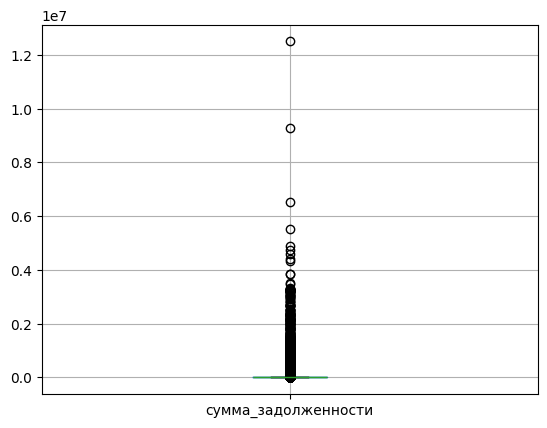


кол-во_месяцев_с_первого_аннуитетного_счета
Доля нанок: 0.0785



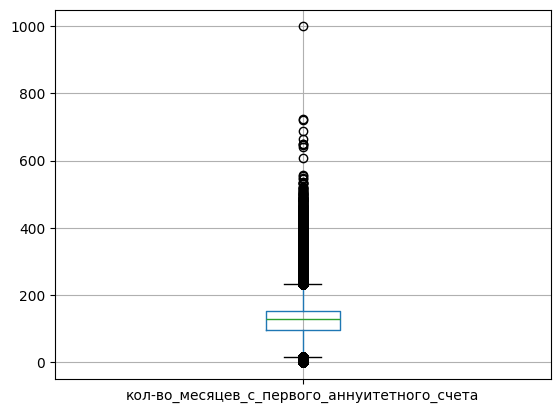


кол-во_месяцев_с_первого_возобновляемого_счета
Доля нанок: 0.0502



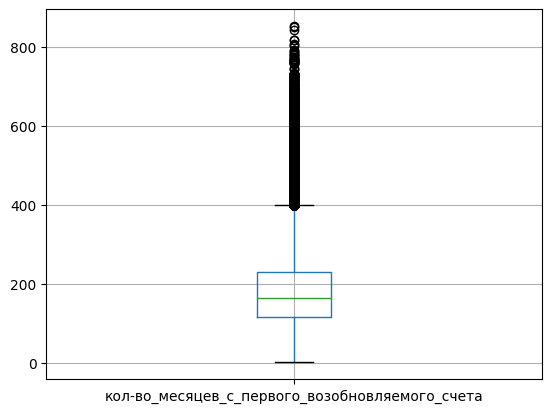


кол-во_месяцев_с_последнего_возобновляемого_счета
Доля нанок: 0.0502



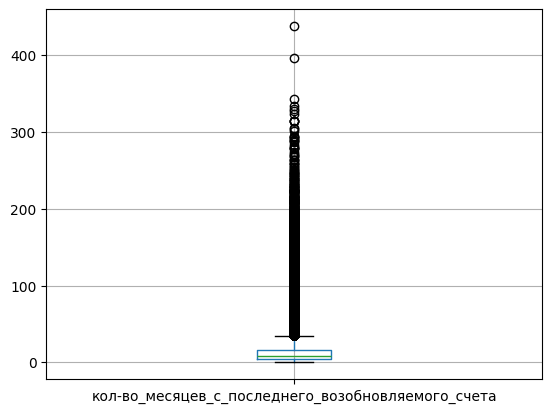


кол-во_месяцев_с_последнего_счета
Доля нанок: 0.0502



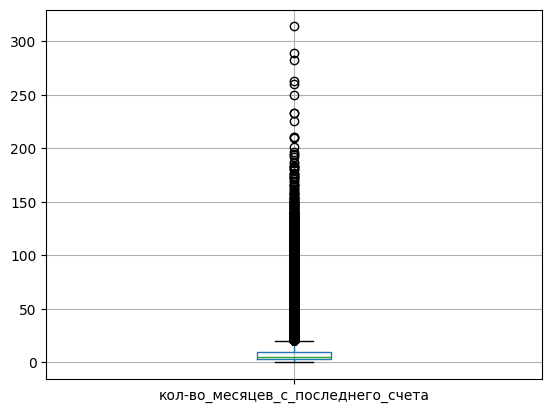


кол-во_ипотек
Доля нанок: 0.0351



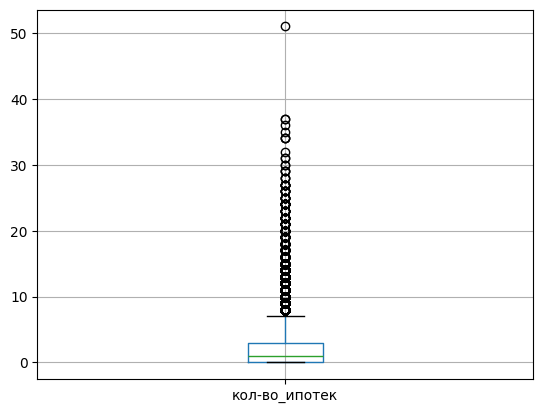


кол-во_месяцев_с_последней_карты
Доля нанок: 0.0447



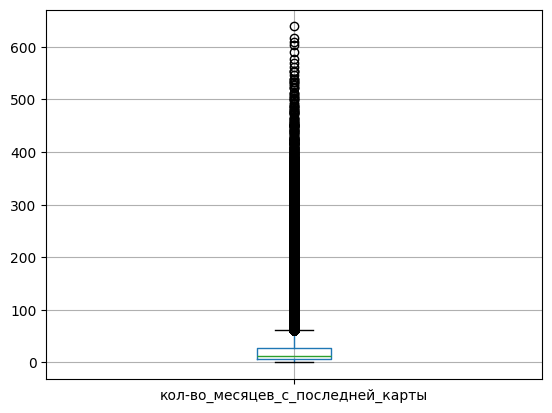


кол-во_мес_с_последней_задолженности_по_карте
Доля нанок: 0.7627



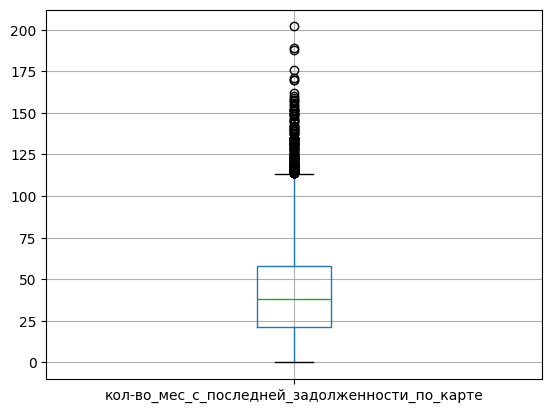


кол-во_мес_с_последней_заявки
Доля нанок: 0.1293



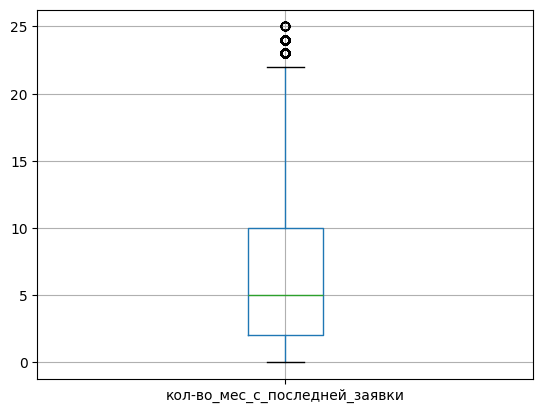


кол-во_мес_с_последней_задолженности_по_возобновляемому_счету
Доля нанок: 0.6654



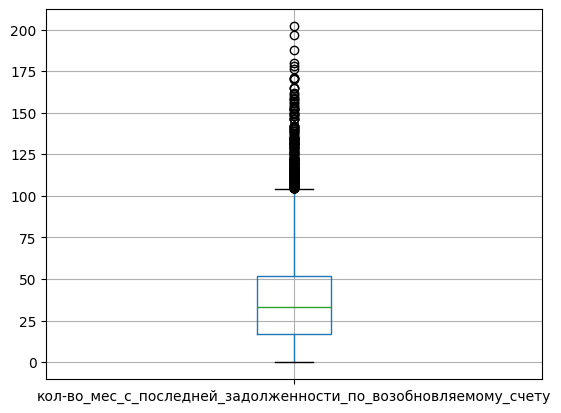


кол-во_счетов_с_просрочкой_4_мес
Доля нанок: 0.0502



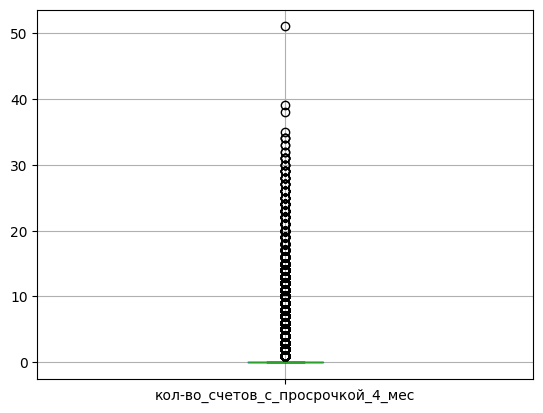


кол-во_активных_карт
Доля нанок: 0.0502



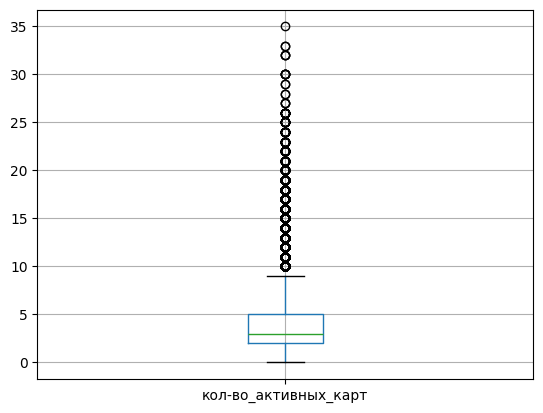


кол-во_активных_возобновляемых_счетов
Доля нанок: 0.0502



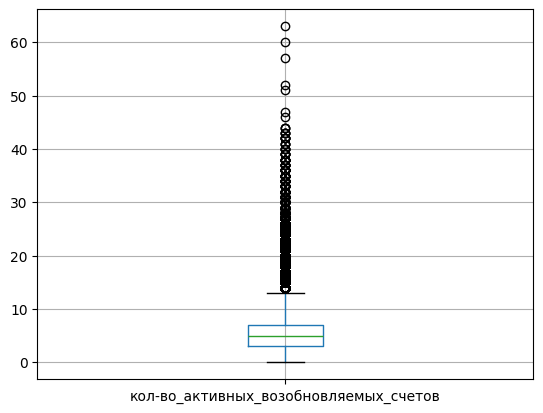


кол-во_карт_без_нарушений
Доля нанок: 0.0415



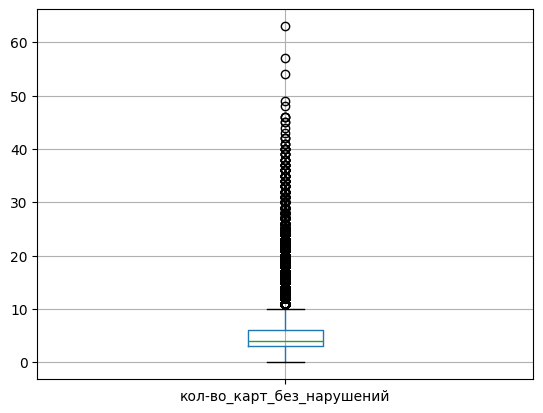


кол-во_карт
Доля нанок: 0.0502



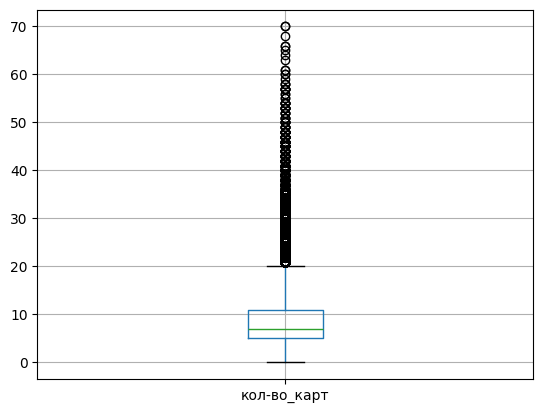


кол-во_аннуитетных_счетов
Доля нанок: 0.0502



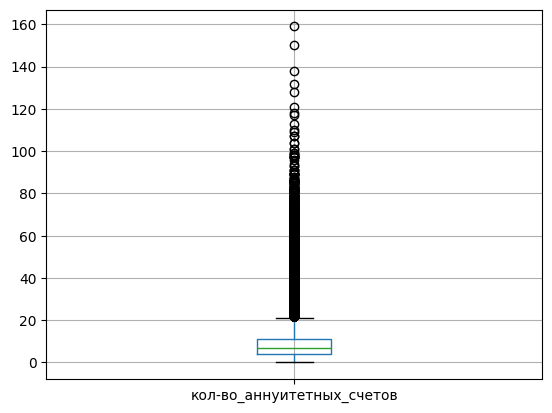


кол-во_открытых_возобновляемых_счетов
Доля нанок: 0.0502



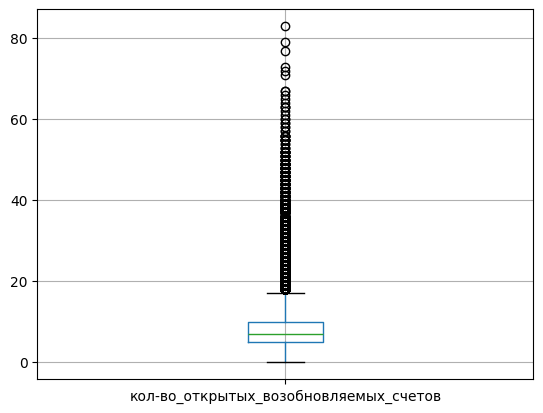


кол-во_возобновляемых_счетов
Доля нанок: 0.0502



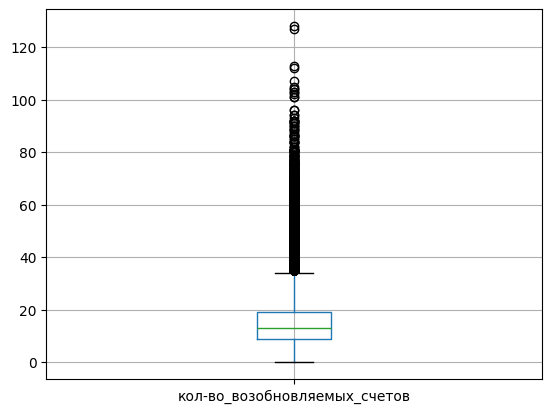


кол-во_возобновляемых_счетов_с_балансом_более_0
Доля нанок: 0.0502



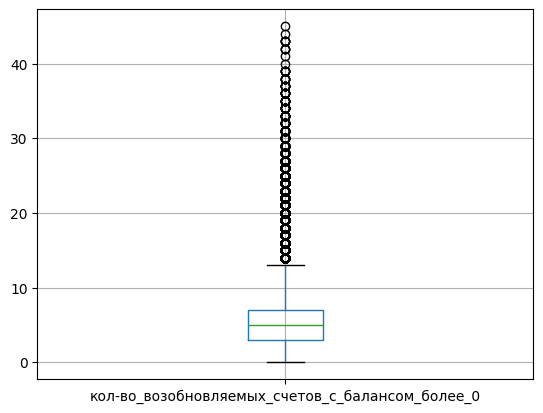


кол-во_счетов_без_нарушений
Доля нанок: 0.0415



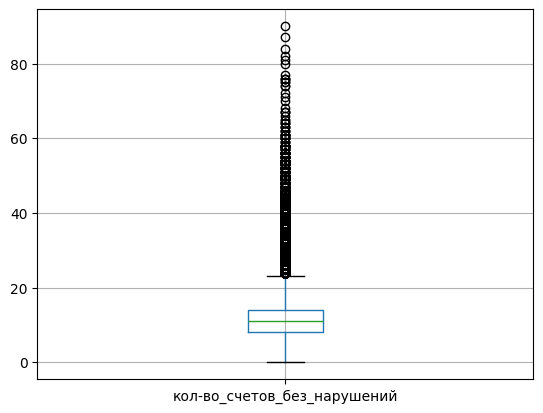


кол-во_счетов_с_акт_просрочкой_4_мес_обн_2_мес
Доля нанок: 0.0871



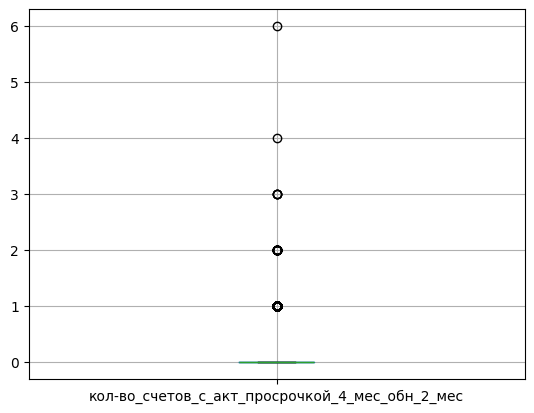


кол-во_счетов_с_акт_просрочкой_1_мес
Доля нанок: 0.0502



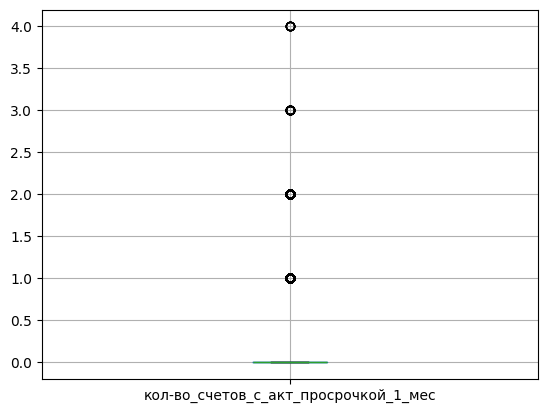


кол-во_счетов_с_акт_просрочкой_3_мес_за_2_года
Доля нанок: 0.0502



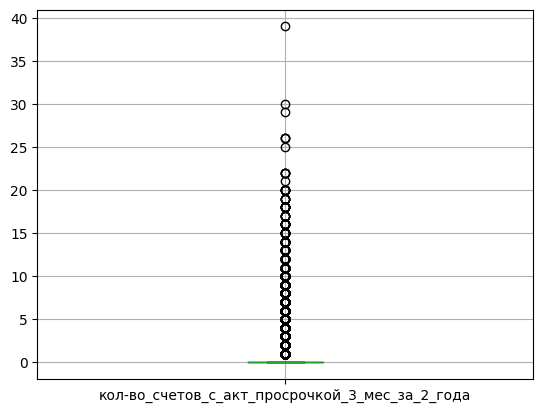


кол-во_счетов_за_посл_год
Доля нанок: 0.0502



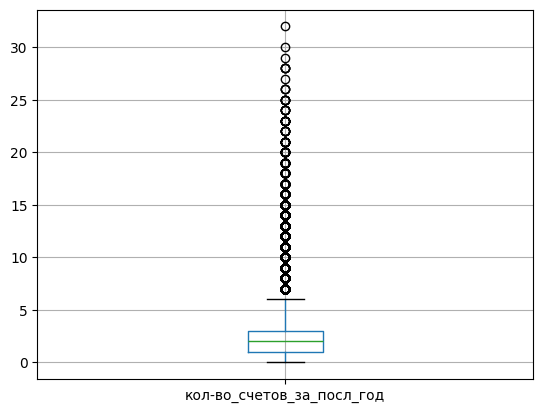


процент_счетов_без_просрочек
Доля нанок: 0.0503



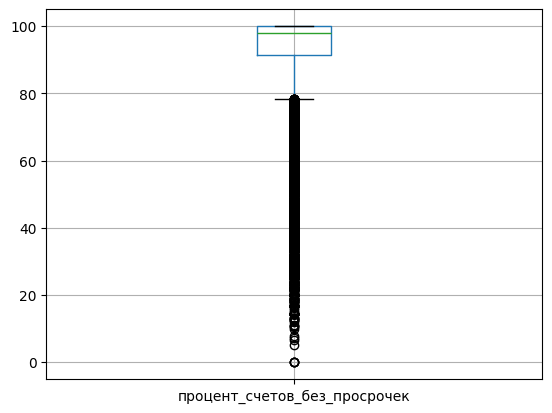


процент_счетов_прев_75_лимита
Доля нанок: 0.0457



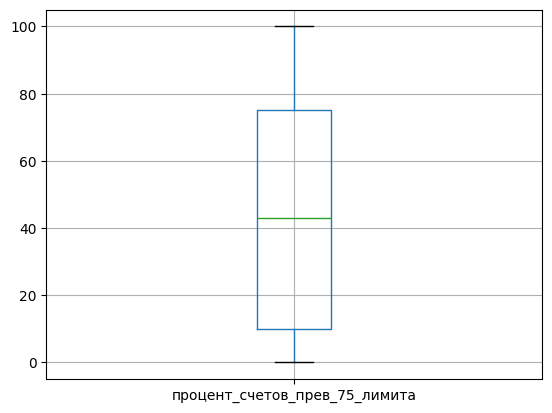


кол-во_публ_банкротств
Доля нанок: 0.0005



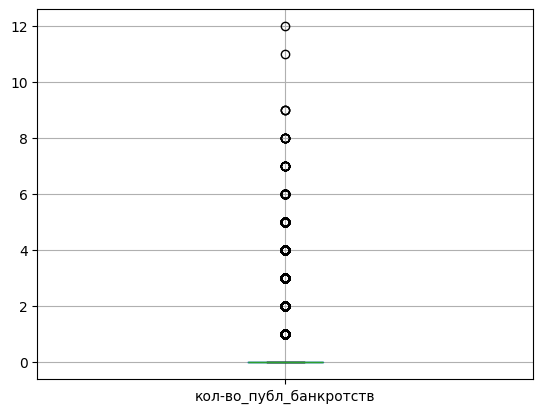


кол-во_залогов
Доля нанок: 0.0



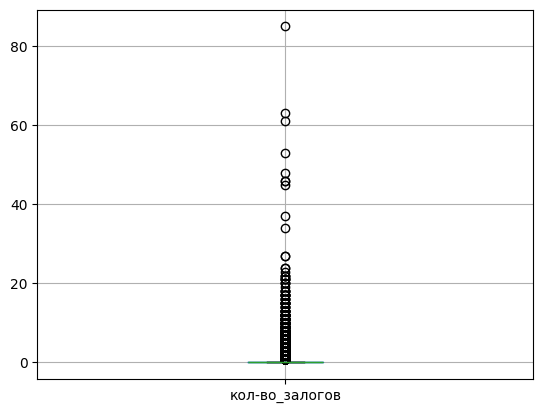


кредитный_лимит
Доля нанок: 0.0502



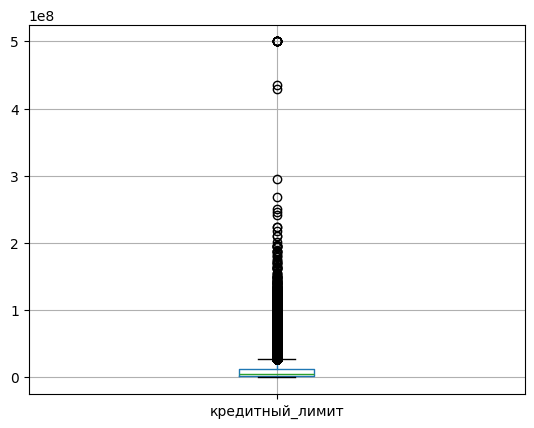


кредитный_баланс_без_ипотеки
Доля нанок: 0.0351



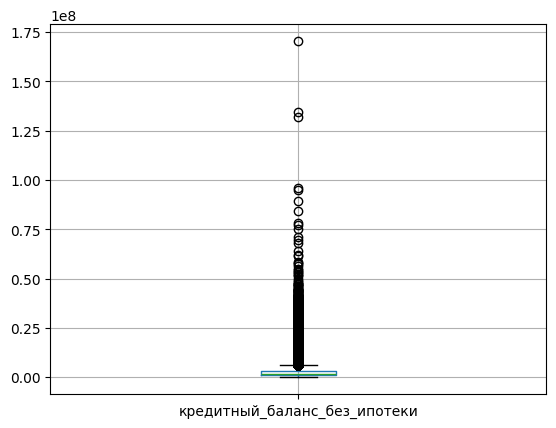


лимит_по_картам
Доля нанок: 0.0351



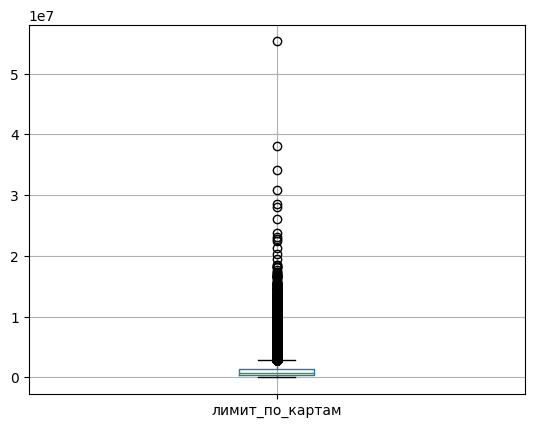


лимит_по_аннуитетным_счетам
Доля нанок: 0.0502



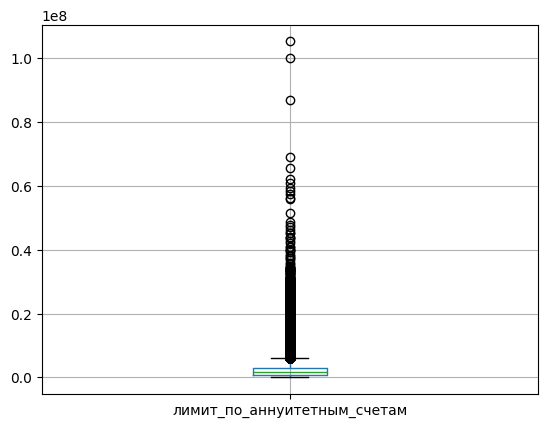

Дропнем следующие столбцы: ['коэфф_невыплаченного_сумм_остатка', 'непогашенная_сумма_из_тела_займов', 'код_политики']
<class 'pandas.DataFrame'>
RangeIndex: 1210779 entries, 0 to 1210778
Data columns (total 81 columns):
 #   Column                                                            Non-Null Count    Dtype  
---  ------                                                            --------------    -----  
 0   сумма_займа                                                       1210779 non-null  float64
 1   процентная_ставка                                                 1210779 non-null  float64
 2   аннуитет                                                          1210779 non-null  float64
 3   годовой_доход                                                     1210779 non-null  float64
 4   итоговый_статус_займа                                             1210779 non-null  int64  
 5   рейтинг_OCR                                                       1210779 non-null  int64  
 6  

In [34]:
if flag_run_eda_section:
    df_num = train.select_dtypes(include=[int, float])

    # дропнем id и 'индекс_проживания' так как они не несут никакой полезной нагрузки
    df_num.drop(['id', 'индекс_проживания'], axis=1, inplace=True)

    droplist = list() # список имен столбцов только с одним значением для дропа

    # пробежимся по всем столбам, соберем статистику, а так же в случае, если столбец содержит отрицательные значения, что в данных есть, но по логике быть не должно
    # то заменим их на нулевые значения
    for column in df_num.columns:
        if len(df_num[column].unique()) == 1:
            droplist.append(column)
            continue
        unique_values = np.sort(df_num[column].unique())
        value_min = unique_values[0]
        print(f'\n{column}\nДоля нанок: {round(df_num[column].isna().sum() / df_num.shape[0], 4)}\n')
        if value_min < 0:
            print(f'Столбец {column} - делаем замену отрицательных значений.')
            df_num[column] = df_num[column].apply(lambda x: 0.0 if x < 0.0 else x)
        df_num.boxplot(column)
        plt.show()

    if len(droplist) > 0:
        print(f'Дропнем следующие столбцы: {droplist}')
        df_num.drop(droplist, axis=1, inplace=True)

    df_num.info()

In [35]:
if flag_run_eda_section:
    # теперь заполним пропуски и сделаем нормализацию. Изначально, я думал заполнить нанки нулями, но исходя из природы представленных финансовых данных,
    # наверное, корректнее всего будет заполнить значением моды, так как, глобально, по логике вещей в бизнесе кредитования основная масса людей - это "хорошие"
    # заемщики, а не склонные к дефолту, в противном случае бизнес кредитования обанкротился бы, поэтому будем использовать самые частые значения
    # подсчет моды сразу по всему датасету ложит мой комп наглухо, поэтому либо через scipy, либо через итерацию по каждому столбцу
    # пойдем по первому пути, так как в этом конкретном случае он работает быстрее у меня и заодно сразу заполним нанки получившейся модой
    for column in df_num.columns:
        df_num[column] = df_num[column].fillna(value=df_num[column].mode()[0])

In [36]:
if flag_run_eda_section:
    df_num.isna().sum()

In [37]:
if flag_run_eda_section:
    # что касается нормализации, то после визуального анализа видно, что разброс значений шкал разных фич большой как относительно других фич, так и у некоторых фич
    # есть существенные выбросы, поэтому я думаю, что степенной трансформер нормализует их наилучшим образом
    df_num_transformed = PowerTransformer(method="yeo-johnson").fit_transform(df_num)
    df_num_trnsf = pd.DataFrame(df_num_transformed, columns=df_num.columns)
    df_num_trnsf.describe()

In [38]:
if flag_run_eda_section:
    # сохраним все фичи в отдельный список
    numbers_list = df_num_trnsf.columns.tolist()
    # print(numbers_list)
    # print(len(numbers_list))

    # общий список фич
    features = numbers_list + category_list
    print('Всего фич отобрано:', len(features))

Всего фич отобрано: 94


Теперь можно собрать все проведенные выше этапы в пайплайн обработки датасетов

In [39]:
# зададим прямо фичи исходя из списков, сформированных ранее, это нужно, чтобы каждый раз EDA блоки уже не запускать
# только вместо 'дней_от_первого_займа' мы возьмем из оригинальных датасетов 'дата_первого_займа', а 'дней_от_первого_займа' уже получим после обработки
# из списка числовых фич уберем таргетную 'итоговый_статус_займа'
categorical_list = ['срок_займа', 'допрейтинг', 'стаж', 'владение_жильем', 'подтвержден_ли_доход', 'цель_займа', 'регион',
                    'пос_стоп_фактор', 'юридический_статус', 'первоначальный_статус_займа', 'тип_займа', 'тип_предоставления_кредита', 'дата_первого_займа']
numerical_list = ['сумма_займа', 'процентная_ставка', 'аннуитет', 'годовой_доход', 'рейтинг_OCR', 'коэфф_акционных_зачислений_в_остатке',
                'кол_во_субсидий_за_год', 'пдн', 'кол-во_просрочек_за_два_года', 'коэфф_исходного_платежа', 'нижний_порог_рейтинга_заемщика',
                'верхний_порог_рейтинга_заемщика', 'кол-во_заявок_за_полгода', 'кол-во_месяцев_с_последней_просрочки', 'кол-во_месяцев_с_последнего_займа',
                'кол-во_открытых_счетов', 'кол-во_записей_в_общедоступных_документах', 'оборотный_баланс', 'коэфф_загрузки_возобновляемого_счета',
                'кол-во_счетов', 'сумма_выплат_по_просрочкам', 'грейд_на_детерминаторе', 'кол-во_взысканий_за_последний_год',
                'кол-во_месяцев_с_последнего_нарушения', 'кол-во_текущих_просроченных_счетов', 'общая_сумма_взысканий', 'возвраты_с_учетом_мпл',
                'общая_сумма_на_счетах', 'кол-во_открытых_счетов_за_полгода', 'кол-во_текущих_аннуитетных_счетов', 'кол-во_аннуитетных_счетов_за_год',
                'кол-во_аннуитетных_счетов_за_2_года', 'кол-во_месяцев_с_посл_аннуитетного_счета', 'текущий_баланс_по_аннуитетным_счетам',
                'соотношение_сумм_текущего_баланса_к_лимиту_по_аннуитетным_счетам', 'кол-во_возоб_счетов_за_год', 'кол-во_возоб_счетов_за_2_года',
                'макс_баланс_по_возоб_счетам', 'соотношение_баланса_к_лимиту_общее', 'общий_лимит_по_возоб_счету', 'кол-во_финансовых_запросов',
                'кол-во_финансовых_операций', 'кол-во_заявок_на_кредит_за_год', 'кол-во_открытых_счетов_за_2_года', 'средний_баланс_текущих_счетов',
                'суммарная_доступная_сумма_займа_по_картам', 'соотношение_баланса_к_лимиту_по_картам', 'кол-во_списаний_за_год', 'сумма_задолженности',
                 'кол-во_месяцев_с_первого_аннуитетного_счета', 'кол-во_месяцев_с_первого_возобновляемого_счета',
                'кол-во_месяцев_с_последнего_возобновляемого_счета', 'кол-во_месяцев_с_последнего_счета', 'кол-во_ипотек', 'кол-во_месяцев_с_последней_карты',
                 'кол-во_мес_с_последней_задолженности_по_карте', 'кол-во_мес_с_последней_заявки',
                'кол-во_мес_с_последней_задолженности_по_возобновляемому_счету', 'кол-во_счетов_с_просрочкой_4_мес', 'кол-во_активных_карт',
                'кол-во_активных_возобновляемых_счетов', 'кол-во_карт_без_нарушений', 'кол-во_карт', 'кол-во_аннуитетных_счетов',
                'кол-во_открытых_возобновляемых_счетов', 'кол-во_возобновляемых_счетов', 'кол-во_возобновляемых_счетов_с_балансом_более_0',
                'кол-во_счетов_без_нарушений', 'кол-во_счетов_с_акт_просрочкой_4_мес_обн_2_мес', 'кол-во_счетов_с_акт_просрочкой_1_мес',
                'кол-во_счетов_с_акт_просрочкой_3_мес_за_2_года', 'кол-во_счетов_за_посл_год', 'процент_счетов_без_просрочек', 'процент_счетов_прев_75_лимита',
                'кол-во_публ_банкротств', 'кол-во_залогов', 'кредитный_лимит', 'кредитный_баланс_без_ипотеки', 'лимит_по_картам', 'лимит_по_аннуитетным_счетам']


In [44]:
# основная функция-пайплайн обработки оригинальных датасетов
def process_data_set(_dataset: pd.DataFrame,
                     _categorical_features: list,
                     _numerical_features: list,
                     _is_train: bool = True,
                     _corr_features: set = None) -> pd.DataFrame:
    print(f'Размер оригинального датасета: {_dataset.shape}')
    df_str = _dataset[_categorical_features]
    df_num = _dataset[_numerical_features]
    df_temp = pd.DataFrame() # временный датафрейм
    df_res = pd.DataFrame() # результирующий датафрейм фич
    df_target = pd.DataFrame() # результирующий датафрейм таргета
    correlated_features = set() # множество для найденных коррелированных фич

    # пройдемся по каждому категориальному столбцу и подготовим данные согласно плану из EDA
    for column in df_str.columns:
        if column == 'допрейтинг': # замена буквы рейтинга на цифру
            df_str[column] = df_str[column].apply(lambda x: rating_le(x))
            df_str[column] = df_str[column].astype(int)
        elif column == 'срок_займа': # переведем года в месяца
            df_str[column] = (df_str[column].apply(lambda x: int(x[0]) * 12)).astype(int)
        elif column == 'стаж': # переведем стаж только в года
            df_str[column] = df_str[column].str.replace('< 1 года', '0')
            df_str[column] = df_str[column].str.replace('10+ лет', '10')
            df_str[column] = df_str[column].fillna('0')
            df_str[column] = (df_str[column].apply(lambda x: x[0])).astype(int)
        elif column == 'дата_первого_займа': # переведем дату первого займа в количество дней, прошедшее с даты
            # первого займа допустим до 02-2026, а сам столбец даты первого займа дропнем из списка итоговых фич
            # новый полученный столбец сразу добавим в результирующий датафрейм
            df_str[column] = pd.to_datetime(df_str[column], format='%m-%Y')
            dt_to_compare = pd.to_datetime('02-2026', format='%m-%Y')
            df_temp['дней_от_первого_займа'] = df_str[column].apply(lambda x: (dt_to_compare - x).days)
            df_str = df_str.drop(column, axis=1)
        else: # остальные столбцы обрабатываем дефолтно кстомым автоматическим LE
            column_keys = df_str[column].unique()
            column_values = np.arange(0, len(column_keys))
            column_dict = dict(zip(column_keys, column_values))

            df_str[column] = df_str[column].apply(lambda x: column_dict[x])
            df_str[column] = df_str[column].astype(int)

    # пройдемся по каждому числовому столбцу и заполним пропуски модой
    for column in df_num.columns:
        df_num[column] = df_num[column].fillna(value=df_num[column].mode()[0])

    # добавим каждый из датасетов к результирующему и нормализуем его перед возвращением
    df_res = pd.concat([df_num, df_str, df_temp], axis=1)
    # df_res_temp = pd.concat([df_num, df_str, df_temp], axis=1)

    # нормализуем результирующий датасет фич
    res_transformed = PowerTransformer(method="yeo-johnson").fit_transform(df_res)
    df_res = pd.DataFrame(res_transformed, columns=df_res.columns)

    if _is_train:
        df_res['итоговый_статус_займа'] = _dataset['итоговый_статус_займа']
        # df_res_temp['итоговый_статус_займа'] = _dataset['итоговый_статус_займа']

    # дропнем дубликаты
    df_res = df_res.drop_duplicates()
    # df_res_temp = df_res_temp.drop_duplicates()
    if _is_train:
        # df_target = df_res_temp['итоговый_статус_займа']
        # df_res_temp = df_res_temp.drop('итоговый_статус_займа', axis=1)

        # используя матрицу корреляций найдем мультиколлинеарные фичи для последующего дропа, порог отсечения выберем и установим как p_max
        p_max = 0.55
        target = 'итоговый_статус_займа'
        df_corr = df_res.corr()
        for i in range(len(df_corr.columns)):
            for j in range(i):
                if abs(df_corr.iloc[i, j]) > p_max and df_corr.columns[i] != target and df_corr.columns[j] != target:
                    if abs(df_corr[target][df_corr.columns[j]]) > abs(df_corr[target][df_corr.columns[i]]):
                        correlated_features.add(df_corr.columns[i])
                    else:
                        correlated_features.add(df_corr.columns[j])
        print(f'Найдены следующие коррелированные фичи: {correlated_features}')
        df_res = df_res.drop(correlated_features, axis=1)
        df_target = df_res['итоговый_статус_займа']
        df_res = df_res.drop('итоговый_статус_займа', axis=1)
    else:
        df_res = df_res.drop(_corr_features, axis=1)

    print(f'Размер результрующего датасета фич: {df_res.shape}')
    print(f'Количество пустых значений:\n{df_res.isna().sum()}')
    print(f'Размер результрующего датасета таргета: {df_target.shape}')
    print(f'Количество пустых значений:\n{df_target.isna().sum()}')
    return df_res, df_target, correlated_features

Общая логика следующих этапов такова:

- разбиваем тренировочный датасет на обучающую и валидационную выборки
- обучаем ряд основных классификаторов, используя, в основном, настройки по дефолту, так как основная цель данной работы в другом
- так как метрика соревнования ROC-AUC, то выберем самую лучшую модель, которая показала самую большую площадь под кривой на валидационной выборке
- сделаем предсказания на тестовой выборке соревнования
- сформируем сабмишн

In [41]:
# сформируем полные тренировочные дата сеты
X_train_full, y_train_full, corr_features = process_data_set(train, categorical_list, numerical_list)
y_train_full.value_counts()

Размер оригинального датасета: (1210779, 103)
Найдены следующие коррелированные фичи: {'кол-во_счетов_без_нарушений', 'кредитный_баланс_без_ипотеки', 'кол-во_месяцев_с_последнего_счета', 'кол-во_возоб_счетов_за_год', 'оборотный_баланс', 'процент_счетов_без_просрочек', 'кол-во_возобновляемых_счетов_с_балансом_более_0', 'кол-во_мес_с_последней_задолженности_по_возобновляемому_счету', 'кол-во_публ_банкротств', 'кредитный_лимит', 'кол-во_аннуитетных_счетов', 'средний_баланс_текущих_счетов', 'процентная_ставка', 'текущий_баланс_по_аннуитетным_счетам', 'кол-во_месяцев_с_последнего_возобновляемого_счета', 'кол-во_открытых_возобновляемых_счетов', 'кол-во_финансовых_запросов', 'кол-во_счетов_с_акт_просрочкой_1_мес', 'кол-во_месяцев_с_посл_аннуитетного_счета', 'кол-во_месяцев_с_последнего_нарушения', 'кол-во_возобновляемых_счетов', 'кол-во_открытых_счетов_за_полгода', 'макс_баланс_по_возоб_счетам', 'кол-во_карт_без_нарушений', 'кол-во_аннуитетных_счетов_за_год', 'дней_от_первого_займа', 'коэфф_з

итоговый_статус_займа
0    969085
1    241694
Name: count, dtype: int64

In [42]:
# обработаем и сформируем датасет тестовых фич
X_test, _, _ = process_data_set(test, categorical_list, numerical_list, False, corr_features)

Размер оригинального датасета: (134531, 108)
Размер результрующего датасета фич: (134531, 49)
Количество пустых значений:
сумма_займа                                                         0
годовой_доход                                                       0
рейтинг_OCR                                                         0
коэфф_акционных_зачислений_в_остатке                                0
кол_во_субсидий_за_год                                              0
пдн                                                                 0
кол-во_просрочек_за_два_года                                        0
коэфф_исходного_платежа                                             0
верхний_порог_рейтинга_заемщика                                     0
кол-во_заявок_за_полгода                                            0
кол-во_месяцев_с_последнего_займа                                   0
кол-во_записей_в_общедоступных_документах                           0
сумма_выплат_по_просрочкам            

In [43]:
# разделим тренировочный датасет на тренировочную и валидационную выборки, чтобы далее была возможность оценить модели и выбрать наиболее качественную
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, train_size=0.7, random_state=9)

In [45]:
# Обучаем логистическую регрессию
model_lr = LogisticRegression(max_iter=500)
model_lr.fit(X_train, y_train)

# Получим предсказания и проведем валидацию модели
y_val_pred = model_lr.predict(X_val)
y_val_pred_1 = model_lr.predict_proba(X_val)[:, 1]
print(f'accuracy {round(accuracy_score(y_val, y_val_pred), 2)}')
print(classification_report(y_val, y_val_pred))

fpr_1, tpr_1, thresholds_1 = roc_curve(y_val, y_val_pred_1)
roc_auc_1 = roc_auc_score(y_val, y_val_pred_1)
roc_auc_1 # 0.7378644916940535

accuracy 0.81
              precision    recall  f1-score   support

           0       0.82      0.98      0.89    290754
           1       0.62      0.14      0.23     72480

    accuracy                           0.81    363234
   macro avg       0.72      0.56      0.56    363234
weighted avg       0.78      0.81      0.76    363234



0.7356496949941267

In [46]:
# Обучаем градиентный бустринг
model_gb = GradientBoostingClassifier(max_depth=5, random_state=8)
model_gb.fit(X_train, y_train)

# Получим предсказания и проведем валидацию модели
y_val_pred = model_gb.predict(X_val)
y_val_pred_1 = model_gb.predict_proba(X_val)[:, 1]
print(f'accuracy {round(accuracy_score(y_val, y_val_pred), 2)}')
print(classification_report(y_val, y_val_pred))

fpr_2, tpr_2, thresholds_2 = roc_curve(y_val, y_val_pred_1)
roc_auc_2 = roc_auc_score(y_val, y_val_pred_1)
roc_auc_2

accuracy 0.81
              precision    recall  f1-score   support

           0       0.82      0.98      0.89    290754
           1       0.63      0.16      0.25     72480

    accuracy                           0.81    363234
   macro avg       0.72      0.57      0.57    363234
weighted avg       0.78      0.81      0.76    363234



0.7441148660083085

In [47]:
# Обучаем дерево решений
model_dt = DecisionTreeClassifier(max_depth=3, random_state=8)
model_dt.fit(X_train, y_train)

# Получим предсказания и проведем валидацию модели
y_val_pred = model_dt.predict(X_val)
y_val_pred_1 = model_dt.predict_proba(X_val)[:, 1]
print(f'accuracy {round(accuracy_score(y_val, y_val_pred), 2)}')
print(classification_report(y_val, y_val_pred))

fpr_3, tpr_3, thresholds_3 = roc_curve(y_val, y_val_pred_1)
roc_auc_3 = roc_auc_score(y_val, y_val_pred_1)
roc_auc_3 # 0.7184844762273362

accuracy 0.81
              precision    recall  f1-score   support

           0       0.81      0.99      0.89    290754
           1       0.65      0.10      0.17     72480

    accuracy                           0.81    363234
   macro avg       0.73      0.54      0.53    363234
weighted avg       0.78      0.81      0.75    363234



0.7040422357008035

In [48]:
# Обучаем случайный лес
model_rf = RandomForestClassifier(max_depth=5, random_state=8)
model_rf.fit(X_train, y_train)

# Получим предсказания и проведем валидацию модели
y_val_pred = model_rf.predict(X_val)
y_val_pred_1 = model_rf.predict_proba(X_val)[:, 1]
print(f'accuracy {round(accuracy_score(y_val, y_val_pred), 2)}')
print(classification_report(y_val, y_val_pred))

fpr_4, tpr_4, thresholds_4 = roc_curve(y_val, y_val_pred_1)
roc_auc_4 = roc_auc_score(y_val, y_val_pred_1)
roc_auc_4 # 0.7275666965096216

accuracy 0.8
              precision    recall  f1-score   support

           0       0.80      1.00      0.89    290754
           1       0.76      0.02      0.04     72480

    accuracy                           0.80    363234
   macro avg       0.78      0.51      0.46    363234
weighted avg       0.80      0.80      0.72    363234



0.72827679786855

In [49]:
# Обучение KNN работает нестабильно на моей машине и зачастую просто ложит ядро юпитера, поэтому я его пропустил в этой итерации
'''
# Обучаем методом ближайших соседей
model_knn = KNeighborsClassifier(n_neighbors=2, algorithm='auto', leaf_size=10)
model_knn.fit(X_train, y_train)

# Получим предсказания и проведем валидацию модели
y_val_pred = model_knn.predict(X_val)
y_val_pred_1 = model_knn.predict_proba(X_val)[:, 1]
print(f'accuracy {round(accuracy_score(y_val, y_val_pred), 2)}')
print(classification_report(y_val, y_val_pred))

fpr_5, tpr_5, thresholds_5 = roc_curve(y_val, y_val_pred_1)
roc_auc_5 = roc_auc_score(y_val, y_val_pred_1)
roc_auc_5 # 0.6251425310479858
'''

"\n# Обучаем методом ближайших соседей\nmodel_knn = KNeighborsClassifier(n_neighbors=2, algorithm='auto', leaf_size=10)\nmodel_knn.fit(X_train, y_train)\n\n# Получим предсказания и проведем валидацию модели\ny_val_pred = model_knn.predict(X_val)\ny_val_pred_1 = model_knn.predict_proba(X_val)[:, 1]\nprint(f'accuracy {round(accuracy_score(y_val, y_val_pred), 2)}')\nprint(classification_report(y_val, y_val_pred))\n\nfpr_5, tpr_5, thresholds_5 = roc_curve(y_val, y_val_pred_1)\nroc_auc_5 = roc_auc_score(y_val, y_val_pred_1)\nroc_auc_5 # 0.6251425310479858\n"

In [50]:
# Обучаем методом адаптивного ускорения
model_ada = AdaBoostClassifier(n_estimators=10, random_state=8)
model_ada.fit(X_train,y_train)

# Получим предсказания и проведем валидацию модели
y_val_pred = model_ada.predict(X_val)
y_val_pred_1 = model_ada.predict_proba(X_val)[:, 1]
print(f'accuracy {round(accuracy_score(y_val, y_val_pred), 2)}')
print(classification_report(y_val, y_val_pred))

fpr_6, tpr_6, thresholds_6 = roc_curve(y_val, y_val_pred_1)
roc_auc_6 = roc_auc_score(y_val, y_val_pred_1)
roc_auc_6 # 0.7315499955295907

accuracy 0.81
              precision    recall  f1-score   support

           0       0.81      0.99      0.89    290754
           1       0.67      0.07      0.13     72480

    accuracy                           0.81    363234
   macro avg       0.74      0.53      0.51    363234
weighted avg       0.78      0.81      0.74    363234



0.7073907807586778

In [51]:
# Обучаем с помощью классификатора CatBoost
model_cat = CatBoostClassifier(iterations=100,
                               depth=2,
                               learning_rate=1,
                               loss_function='Logloss',
                               early_stopping_rounds=50,
                               custom_metric=['AUC'],
                               random_seed=8)
model_cat.fit(X_train,y_train)

# Получим предсказания и проведем валидацию модели
y_val_pred = model_cat.predict(X_val)
y_val_pred_1 = model_cat.predict_proba(X_val)[:, 1]
print(f'accuracy {round(accuracy_score(y_val, y_val_pred), 2)}')
print(classification_report(y_val, y_val_pred))

fpr_7, tpr_7, thresholds_7 = roc_curve(y_val, y_val_pred_1)
roc_auc_7 = roc_auc_score(y_val, y_val_pred_1)
roc_auc_7 # 0.7510424569637716

0:	learn: 0.4592434	total: 114ms	remaining: 11.3s
1:	learn: 0.4523760	total: 162ms	remaining: 7.93s
2:	learn: 0.4490453	total: 211ms	remaining: 6.82s
3:	learn: 0.4463757	total: 254ms	remaining: 6.09s
4:	learn: 0.4438507	total: 318ms	remaining: 6.05s
5:	learn: 0.4427699	total: 375ms	remaining: 5.87s
6:	learn: 0.4417561	total: 434ms	remaining: 5.76s
7:	learn: 0.4409406	total: 485ms	remaining: 5.58s
8:	learn: 0.4401558	total: 552ms	remaining: 5.58s
9:	learn: 0.4395194	total: 609ms	remaining: 5.48s
10:	learn: 0.4391217	total: 661ms	remaining: 5.35s
11:	learn: 0.4387917	total: 738ms	remaining: 5.41s
12:	learn: 0.4384826	total: 796ms	remaining: 5.33s
13:	learn: 0.4380633	total: 858ms	remaining: 5.27s
14:	learn: 0.4377974	total: 990ms	remaining: 5.61s
15:	learn: 0.4375707	total: 1.08s	remaining: 5.65s
16:	learn: 0.4372654	total: 1.21s	remaining: 5.89s
17:	learn: 0.4370752	total: 1.3s	remaining: 5.95s
18:	learn: 0.4368612	total: 1.4s	remaining: 5.99s
19:	learn: 0.4366583	total: 1.51s	remaining

0.7470179106931781

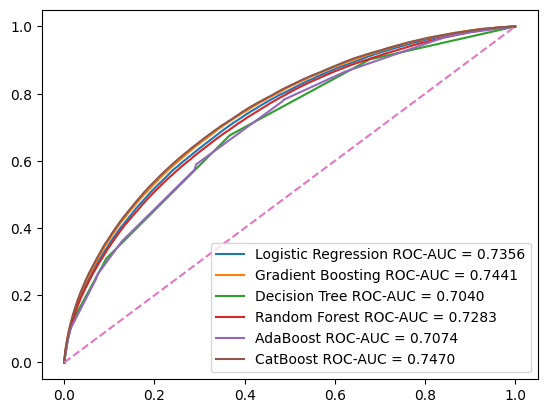

In [52]:
# Построим общий график всех ROC-AUC
plt.plot(fpr_1, tpr_1, label='Logistic Regression ROC-AUC = %.4f' %roc_auc_1)
plt.plot(fpr_2, tpr_2, label='Gradient Boosting ROC-AUC = %.4f' %roc_auc_2)
plt.plot(fpr_3, tpr_3, label='Decision Tree ROC-AUC = %.4f' %roc_auc_3)
plt.plot(fpr_4, tpr_4, label = 'Random Forest ROC-AUC = %.4f' %roc_auc_4)
# plt.plot(fpr_5, tpr_5, label = 'KNN ROC-AUC = %.4f' %roc_auc_5)
plt.plot(fpr_6, tpr_6, label = 'AdaBoost ROC-AUC = %.4f' %roc_auc_6)
plt.plot(fpr_7, tpr_7, label = 'CatBoost ROC-AUC = %.4f' %roc_auc_7)
plt.plot([0, 1], [0, 1], linestyle = '--')
plt.legend()
plt.show()

In [53]:
# исходя из полученных данных модель CatBoost'a показывает себя лучше всех остальных (максимальная площадь под кривой)
# выберем ее в качестве основной модели

# Получим предсказания
test_predict = model_cat.predict_proba(X_test)[:, 1]

In [54]:
# Формируем сабмит
answer = pd.DataFrame()
answer['id'] = test['id']
answer['proba'] = test_predict
answer.to_csv('submission.csv', index=False)